<a href="https://colab.research.google.com/github/Asalasadat/Project-FC-Work-zone/blob/main/FC_Projectfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import re
import numpy as np
from threading import Thread
import math
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
#Connect to Google Drive to import CSV files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Roundabout

In [ ]:
# Check if the folder exists and get all CSV files from the research directory
folder_path_round = Path("/content/drive/MyDrive/FC Research/datarounD")
if folder_path_round.exists():
    csv_files_round = [file.as_posix() for file in folder_path_round.iterdir() if file.is_file() and file.suffix == ".csv"]
else:
    csv_files_round = []
    print("Folder does not exist!")
csv_files_round

['/content/drive/MyDrive/FC Research/datarounD/04_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/18_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/21_tracksMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/01_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/00_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/05_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/19_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/03_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/20_tracksMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/22_tracksMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/06_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/02_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/12_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datarounD/17_tracksMeta.csv',
 '/content/drive/MyDrive/FC Rese

**Reads all CSV files in the folder, keeps only rows where class is "car", retains key columns (recordingId, trackId, lonVelocity, lonAcceleration, xCenter, yCenter, frame, xAcceleration), fills missing columns with NaN, and removes rows with missing values.**

In [ ]:
# Load and merge vehicle (car) metadata, track data, and recording info from multiple CSV files
meta_files = list(folder_path_round.glob("*_tracksMeta.csv"))
tracks_files = list(folder_path_round.glob("*_tracks.csv"))
recording_files = list(folder_path_round.glob("*_recordingMeta.csv"))

meta_list = []
for file in meta_files:
    df_meta = pd.read_csv(file)
    if "class" in df_meta.columns:
        df_meta = df_meta[df_meta["class"] == "car"]
        meta_list.append(df_meta[["recordingId", "trackId", "class"]])

cars_meta = pd.concat(meta_list, ignore_index=True)

tracks_list = []
for file in tracks_files:
    df_tracks = pd.read_csv(file)
    tracks_list.append(df_tracks)

tracks = pd.concat(tracks_list, ignore_index=True)

cars_tracks = tracks.merge(cars_meta, on=["recordingId", "trackId"], how="inner")

rec_list = []
for file in recording_files:
    df_rec = pd.read_csv(file)
    rec_list.append(df_rec)

recording_meta = pd.concat(rec_list, ignore_index=True)

cars_tracks = cars_tracks.merge(recording_meta, on="recordingId", how="left")
#filter essential columns and remove missing values
col_list = ["recordingId","trackId","lonVelocity","lonAcceleration","xCenter","yCenter","frame","xAcceleration"]
cars_tracks = cars_tracks[col_list].dropna()


In [ ]:
cars_tracks

,recordingId,trackId,lonVelocity,lonAcceleration,xCenter,yCenter,frame,xAcceleration
0,7,14,7.8720,0.9321,98.4698,-59.3441,0,-1.8095
1,7,14,7.9325,0.9590,98.6169,-59.0661,1,-1.8666
2,7,14,7.9940,0.9725,98.7636,-58.7817,2,-1.9308
3,7,14,8.0552,0.9731,98.9081,-58.4918,3,-2.0014
4,7,14,8.1151,0.9622,99.0507,-58.1971,4,-2.0775
...,...,...,...,...,...,...,...,...
4358521,9,710,8.6414,1.4966,84.2029,-68.5019,26743,2.5693
4358522,9,710,8.7103,1.5304,84.5236,-68.3638,26744,2.5702
4358523,9,710,8.7800,1.5625,84.8487,-68.2290,26745,2.5705
4358524,9,710,8.8501,1.5938,85.1785,-68.0966,26746,2.5705


In [ ]:
# Select a random sample of up to 25000 unique vehicles and extract specific driving data for them.
unique_vehicles = cars_tracks[['recordingId', 'trackId']].drop_duplicates()
sample_size = min(3000, len(unique_vehicles))
sample_vehicles = unique_vehicles.sample(n=sample_size, random_state=42)
df_original_round = cars_tracks.merge(sample_vehicles, on=['recordingId', 'trackId'], how='inner')
df_original_round = df_original_round[['recordingId','trackId','lonVelocity','lonAcceleration','xCenter','yCenter','frame','xAcceleration']]
df_original_round

,recordingId,trackId,lonVelocity,lonAcceleration,xCenter,yCenter,frame,xAcceleration
0,7,14,7.8720,0.9321,98.4698,-59.3441,0,-1.8095
1,7,14,7.9325,0.9590,98.6169,-59.0661,1,-1.8666
2,7,14,7.9940,0.9725,98.7636,-58.7817,2,-1.9308
3,7,14,8.0552,0.9731,98.9081,-58.4918,3,-2.0014
4,7,14,8.1151,0.9622,99.0507,-58.1971,4,-2.0775
...,...,...,...,...,...,...,...,...
1091894,9,709,7.0678,1.9155,100.4789,-38.7617,26743,-1.5455
1091895,9,709,7.1442,1.9167,100.2909,-38.5480,26744,-1.5465
1091896,9,709,7.2205,1.9180,100.1003,-38.3327,26745,-1.5469
1091897,9,709,7.2967,1.9192,99.9074,-38.1156,26746,-1.5470


In [ ]:
# Display summary statistics for the original round dataset
df_original_round.describe()

,recordingId,trackId,lonVelocity,lonAcceleration,xCenter,yCenter,frame,xAcceleration
count,1.091899e+06,1.091899e+06,1.091899e+06,1.091899e+06,1.091899e+06,1.091899e+06,1.091899e+06,1.091899e+06
mean,1.165004e+01,3.159321e+02,6.574615e+00,2.788758e-01,8.280490e+01,-4.833155e+01,1.299449e+04,4.083565e-02
std,6.772400e+00,1.950048e+02,3.296309e+00,8.816844e-01,2.482402e+01,1.945287e+01,7.953625e+03,1.391091e+00
min,0.000000e+00,2.000000e+00,-2.657000e-01,-5.470900e+00,1.549370e+01,-1.409123e+02,0.000000e+00,-9.960200e+00
25%,6.000000e+00,1.480000e+02,4.652500e+00,-1.464000e-01,6.440545e+01,-6.328550e+01,6.109000e+03,-8.928000e-01
50%,1.100000e+01,2.920000e+02,7.189000e+00,2.615000e-01,8.313170e+01,-4.811200e+01,1.239000e+04,1.940000e-02
75%,1.800000e+01,4.720000e+02,8.646200e+00,7.931000e-01,9.906650e+01,-3.280320e+01,1.959900e+04,9.493000e-01
max,2.300000e+01,7.850000e+02,2.079890e+01,9.229400e+00,1.711881e+02,2.100000e-01,3.123900e+04,8.451600e+00


In [ ]:
# Count and display the number of unique drivers based on recordingId and trackId
num_drivers = df_original_round[['recordingId', 'trackId']].drop_duplicates().shape[0]
print("Number of Drivers", num_drivers)

Number of Drivers 3000


**Standard deviation of speed**
$$
VM1 = \sqrt{\frac{\sum_{i=1}^{N} (V_i - \bar{V})^2}{N}}
$$

In [ ]:
# calculate VM1
VMR1 = (df_original_round.groupby(['recordingId','trackId']).agg(VM1=('xAcceleration', 'std')).reset_index())
VMR1

,recordingId,trackId,VM1
0,0,24,1.051100
1,0,28,1.088185
2,0,30,1.167340
3,0,34,1.558082
4,0,39,1.445874
...,...,...,...
2995,23,440,0.802233
2996,23,446,1.635398
2997,23,452,0.949206
2998,23,459,0.469282


**Standard deviation of longitudinal deceleration or acceleration**
$$
VM2 = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( ADlong_i - \overline{ADlong} \right)^2 }
$$

In [ ]:
#calculate VM2
VMR2 = (df_original_round.groupby(['recordingId','trackId']).agg(VM2=('lonAcceleration', 'std')).reset_index())
VMR2

,recordingId,trackId,VM2
0,0,24,1.011002
1,0,28,1.113359
2,0,30,0.780974
3,0,34,1.239627
4,0,39,0.828928
...,...,...,...
2995,23,440,0.490047
2996,23,446,0.739453
2997,23,452,0.891482
2998,23,459,0.383552


In [ ]:
def calculate_mad(x):
    return (x - x.mean()).abs().mean()

**Coefficient of variation of speed**
$$
VM3 = 100 \times \frac{\sqrt{\frac{1}{N}\sum_{i=1}^{N} (V_i - \overline{V})^2}}{V}
$$

In [ ]:
#calculate VM3
df_VMR3 = (df_original_round.groupby(['recordingId','trackId']).agg(avgV=('lonVelocity','mean'),stdV=('lonVelocity','std')))
df_VMR3['VM3'] = 100 * df_VMR3['stdV'] / df_VMR3['avgV']
df_VMR3 = df_VMR3[['VM3']].reset_index()
df_VMR3

,recordingId,trackId,VM3
0,0,24,25.550630
1,0,28,39.684445
2,0,30,22.325024
3,0,34,23.892713
4,0,39,22.288779
...,...,...,...
2995,23,440,15.377451
2996,23,446,13.036836
2997,23,452,84.129792
2998,23,459,36.807205


**Coefficient of variation of longitudinal acceleration**

$$
VM4 = 100 \times \frac{\sqrt{\frac{1}{N}\sum_{i=1}^{N} (Along_i - \overline{Along})^2}}{\overline{Along}}
$$

In [ ]:
#calculate VM4
filtered_accel_df = df_original_round[df_original_round['lonAcceleration'] >= 0]
df_VMR4 = (filtered_accel_df.groupby(['recordingId','trackId']).agg(avgA=('lonAcceleration','mean'),stdA=('lonAcceleration','std')))
df_VMR4['VM4'] = 100 * df_VMR4['stdA'] / df_VMR4['avgA']
df_VMR4 = df_VMR4[['VM4']].reset_index()
df_VMR4


,recordingId,trackId,VM4
0,0,24,40.580632
1,0,28,68.151935
2,0,30,43.455024
3,0,34,48.983935
4,0,39,38.760601
...,...,...,...
2994,23,440,73.091682
2995,23,446,64.697613
2996,23,452,55.549777
2997,23,459,41.990634


**Coefficient of variation of longitudinal deceleration**
$$
VM5 = 100 \times \frac{\sqrt{\frac{1}{N}\sum_{i=1}^{N} (Dlong_i - \overline{Dlong})^2}}{\overline{Dlong}}
$$

In [ ]:
#calculate VM5
filtered_decel_df = df_original_round[df_original_round['lonAcceleration'] < 0]
df_VMR5 = (filtered_decel_df.groupby(['recordingId','trackId']).agg(avgD=('lonAcceleration','mean'),stdD=('lonAcceleration','std')))
df_VMR5['VM5'] = 100 * df_VMR5['stdD'] / df_VMR5['avgD'].abs()
df_VMR5 = df_VMR5[['VM5']].reset_index()
df_VMR5

,recordingId,trackId,VM5
0,0,24,80.226924
1,0,28,74.220548
2,0,30,58.935287
3,0,34,74.563848
4,0,39,48.704259
...,...,...,...
2855,23,437,56.483524
2856,23,440,47.635132
2857,23,446,101.974025
2858,23,452,88.236910


**Mean absolute deviation of speed**
$$
VM6 = \frac{1}{N} \sum_{i=1}^{N} |V_i - \overline{V}|
$$

In [ ]:
#calculate VM6
df_VMR6 = df_original_round.groupby(['recordingId', 'trackId']).agg(VM6=('lonVelocity', calculate_mad)).reset_index()
df_VMR6

,recordingId,trackId,VM6
0,0,24,1.465407
1,0,28,2.018697
2,0,30,1.290167
3,0,34,1.676036
4,0,39,1.632974
...,...,...,...
2995,23,440,0.929063
2996,23,446,0.765538
2997,23,452,3.655431
2998,23,459,2.343399


**Mean absolute deviation of longitudinal acceleration**
$$
VM7 = \frac{1}{N} \sum_{i=1}^{N} |Along_i - \overline{Along}|
$$

In [ ]:
#calculate VM7
filtered_accel_df = df_original_round[df_original_round['lonAcceleration'] >= 0]
VMR7 = filtered_accel_df.groupby(['recordingId', 'trackId']).agg(VM7=('lonAcceleration', calculate_mad)).reset_index()
VMR7

,recordingId,trackId,VM7
0,0,24,0.208668
1,0,28,0.406132
2,0,30,0.313354
3,0,34,0.608439
4,0,39,0.233357
...,...,...,...
2994,23,440,0.247821
2995,23,446,0.301873
2996,23,452,0.402118
2997,23,459,0.330930


**Quantile coefficient of variation of normalised speed**
$$
VM8 = 100 \times \frac{Q_3(V) - Q_1(V)}{Q_3(V) + Q_1(V)}
$$

In [ ]:
def q1(x):
    return x.quantile(0.25)


def q3(x):
    return x.quantile(0.75)

In [ ]:
#calculate VM8
df_VMR8 = df_original_round.groupby(['recordingId','trackId']).agg(q1_speed=('lonVelocity', q1),q3_speed=('lonVelocity', q3)).reset_index()
df_VMR8['VM8'] = 100 * (df_VMR8['q3_speed'] - df_VMR8['q1_speed']) / (df_VMR8['q3_speed'] + df_VMR8['q1_speed'])
df_VMR8 = df_VMR8[['recordingId','trackId','VM8']]
df_VMR8

,recordingId,trackId,VM8
0,0,24,19.484076
1,0,28,23.321551
2,0,30,13.497839
3,0,34,18.923588
4,0,39,18.116949
...,...,...,...
2995,23,440,13.334261
2996,23,446,7.771294
2997,23,452,86.485665
2998,23,459,26.621457


**Quantile coefficient of variation of longitudinal acceleration**

$$
VM9 = 100 \times \frac{Q3(Along) - Q1(Along)}{Q3(Along) + Q1(Along)}
$$

In [ ]:
#calculate VM9
filtered_accel_df = df_original_round[df_original_round['lonAcceleration'] >= 0]
df_VMR9 = filtered_accel_df.groupby(['recordingId','trackId']).agg(q1_acc=('lonAcceleration', q1),q3_acc=('lonAcceleration', q3)).reset_index()
df_VMR9['VM9'] = 100 * (df_VMR9['q3_acc'] - df_VMR9['q1_acc']) / (df_VMR9['q3_acc'] + df_VMR9['q1_acc'])
df_VMR9 = df_VMR9[['recordingId','trackId','VM9']]
df_VMR9

,recordingId,trackId,VM9
0,0,24,28.820230
1,0,28,53.185906
2,0,30,28.871004
3,0,34,44.851073
4,0,39,26.886345
...,...,...,...
2994,23,440,56.814548
2995,23,446,56.777635
2996,23,452,45.508517
2997,23,459,37.517770


**Quantile coefficient of variation of longitudinal deceleration**

$$
VM10 = 100 \times \frac{Q3(Dlong) - Q1(Dlong)}{Q3(Dlong) + Q1(Dlong)}
$$

In [ ]:
#calculate VM10
filtered_accel_df = df_original_round[df_original_round['lonAcceleration'] < 0]
df_VMR10 = filtered_accel_df.groupby(['recordingId', 'trackId'])['lonAcceleration'].agg([q1, q3, 'max'])
VMR10_1 = 100 * abs(df_VMR10['q3'] - df_VMR10['q1']) / abs(df_VMR10['q3'] + df_VMR10['q1'])
VMR10 = VMR10_1.to_frame(name='VM10')
VMR10

VM10
recordingId trackId           
0           24       68.842048
            28       72.507894
            30       37.726348
            34       57.059410
            39       40.261267
...                        ...
23          437      44.648230
            440      36.157152
            446      42.299336
            452      96.079229
            462      48.528795

[2860 rows x 1 columns]

In [ ]:
# Merge all VMR dataframes on recordingId and trackId, then label the infrastructure type as 'roundabout'
pdList = [VMR1, VMR2, df_VMR3,df_VMR4, df_VMR5, df_VMR6, VMR7, df_VMR8, df_VMR9, VMR10]  # List of your dataframes
final_VM_round = reduce(lambda left, right: pd.merge(left, right, on=['recordingId', 'trackId'], how='inner'), pdList)
final_VM_round['infrastructure'] = 'roundabout'
final_VM_round

,recordingId,trackId,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10,infrastructure
0,0,24,1.051100,1.011002,25.550630,40.580632,80.226924,1.465407,0.208668,19.484076,28.820230,68.842048,roundabout
1,0,28,1.088185,1.113359,39.684445,68.151935,74.220548,2.018697,0.406132,23.321551,53.185906,72.507894,roundabout
2,0,30,1.167340,0.780974,22.325024,43.455024,58.935287,1.290167,0.313354,13.497839,28.871004,37.726348,roundabout
3,0,34,1.558082,1.239627,23.892713,48.983935,74.563848,1.676036,0.608439,18.923588,44.851073,57.059410,roundabout
4,0,39,1.445874,0.828928,22.288779,38.760601,48.704259,1.632974,0.233357,18.116949,26.886345,40.261267,roundabout
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854,23,437,2.100742,0.465380,8.328063,69.260938,56.483524,0.551588,0.253800,5.355545,48.370366,44.648230,roundabout
2855,23,440,0.802233,0.490047,15.377451,73.091682,47.635132,0.929063,0.247821,13.334261,56.814548,36.157152,roundabout
2856,23,446,1.635398,0.739453,13.036836,64.697613,101.974025,0.765538,0.301873,7.771294,56.777635,42.299336,roundabout
2857,23,452,0.949206,0.891482,84.129792,55.549777,88.236910,3.655431,0.402118,86.485665,45.508517,96.079229,roundabout


In [ ]:
# Display summary statistics for the final roundabout dataset
final_VM_round.describe()

,recordingId,trackId,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10
count,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000
mean,11.609304,317.958377,1.243601,0.765191,35.035759,69.403703,70.404900,1.734176,0.406466,28.885482,52.754436,55.312673
std,6.797907,195.536568,0.459710,0.311445,27.679624,18.262583,25.415684,0.967255,0.166359,27.190490,16.448803,20.908738
min,0.000000,2.000000,0.195805,0.168975,0.949736,25.842296,0.000000,0.079605,0.028856,0.213647,4.391198,0.000000
25%,6.000000,150.000000,0.886617,0.527881,14.442650,56.666141,51.168854,0.942729,0.290234,8.798778,41.775929,38.898259
50%,11.000000,293.000000,1.222405,0.709315,25.577851,67.339784,65.806491,1.560284,0.396413,17.710475,51.973395,53.464216
75%,18.000000,471.500000,1.545877,0.966429,50.215587,79.439146,84.933365,2.565417,0.501628,42.102063,63.581207,71.880105
max,23.000000,785.000000,2.973676,3.206272,212.769732,195.387236,207.188927,4.491700,3.260603,100.491961,98.607513,99.293333


# k_means clustering Roundabout

In [ ]:
# Remove identifier and infrastructure columns to keep only feature data
VM_round=final_VM_round.drop(['recordingId','trackId','infrastructure'],axis=1)
VM_round

,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10
0,1.051100,1.011002,25.550630,40.580632,80.226924,1.465407,0.208668,19.484076,28.820230,68.842048
1,1.088185,1.113359,39.684445,68.151935,74.220548,2.018697,0.406132,23.321551,53.185906,72.507894
2,1.167340,0.780974,22.325024,43.455024,58.935287,1.290167,0.313354,13.497839,28.871004,37.726348
3,1.558082,1.239627,23.892713,48.983935,74.563848,1.676036,0.608439,18.923588,44.851073,57.059410
4,1.445874,0.828928,22.288779,38.760601,48.704259,1.632974,0.233357,18.116949,26.886345,40.261267
...,...,...,...,...,...,...,...,...,...,...
2854,2.100742,0.465380,8.328063,69.260938,56.483524,0.551588,0.253800,5.355545,48.370366,44.648230
2855,0.802233,0.490047,15.377451,73.091682,47.635132,0.929063,0.247821,13.334261,56.814548,36.157152
2856,1.635398,0.739453,13.036836,64.697613,101.974025,0.765538,0.301873,7.771294,56.777635,42.299336
2857,0.949206,0.891482,84.129792,55.549777,88.236910,3.655431,0.402118,86.485665,45.508517,96.079229


In [ ]:
# Cap outliers in VM3–VM5 at the 95th percentile and normalize all VM features using Min-Max scaling
for col in ['VM3', 'VM4', 'VM5']:
    upper_limit = VM_round[col].quantile(0.95)
    VM_round[col] = np.where(VM_round[col] > upper_limit, upper_limit, VM_round[col])

scaler = MinMaxScaler()
VM_cols = [f'VM{i}' for i in range(1, 11)]
df_scaled = pd.DataFrame(scaler.fit_transform(VM_round[VM_cols]), columns=VM_cols)

print(df_scaled.head())

        VM1       VM2       VM3       VM4       VM5       VM6       VM7  \
0  0.307896  0.277229  0.269245  0.198044  0.677553  0.314092  0.055639   
1  0.321246  0.310929  0.423933  0.568529  0.626827  0.439495  0.116741   
2  0.349741  0.201495  0.233942  0.236668  0.497736  0.274373  0.088032   
3  0.490403  0.352501  0.251100  0.310962  0.629726  0.361831  0.179340   
4  0.450010  0.217283  0.233546  0.173588  0.411330  0.352071  0.063279   

        VM8       VM9      VM10  
0  0.192169  0.259287  0.693320  
1  0.230438  0.517901  0.730239  
2  0.132473  0.259826  0.379948  
3  0.186580  0.429436  0.574655  
4  0.178536  0.238761  0.405478  


In [ ]:
# VM_round = VM_round.reset_index(drop=True)

In [ ]:
# scaler = MinMaxScaler()
# VM_scaled = scaler.fit_transform(VM_round)

In [ ]:
# Apply K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_scaled)
clusters = kmeans.labels_

In [ ]:
# Add cluster labels to the final roundabout dataset
final_VM_round = final_VM_round.loc[df_scaled.index]
final_VM_round['cluster'] = clusters
final_VM_round

,recordingId,trackId,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10,infrastructure,cluster
0,0,24,1.051100,1.011002,25.550630,40.580632,80.226924,1.465407,0.208668,19.484076,28.820230,68.842048,roundabout,1
1,0,28,1.088185,1.113359,39.684445,68.151935,74.220548,2.018697,0.406132,23.321551,53.185906,72.507894,roundabout,0
2,0,30,1.167340,0.780974,22.325024,43.455024,58.935287,1.290167,0.313354,13.497839,28.871004,37.726348,roundabout,1
3,0,34,1.558082,1.239627,23.892713,48.983935,74.563848,1.676036,0.608439,18.923588,44.851073,57.059410,roundabout,1
4,0,39,1.445874,0.828928,22.288779,38.760601,48.704259,1.632974,0.233357,18.116949,26.886345,40.261267,roundabout,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854,23,437,2.100742,0.465380,8.328063,69.260938,56.483524,0.551588,0.253800,5.355545,48.370366,44.648230,roundabout,1
2855,23,440,0.802233,0.490047,15.377451,73.091682,47.635132,0.929063,0.247821,13.334261,56.814548,36.157152,roundabout,1
2856,23,446,1.635398,0.739453,13.036836,64.697613,101.974025,0.765538,0.301873,7.771294,56.777635,42.299336,roundabout,1
2857,23,452,0.949206,0.891482,84.129792,55.549777,88.236910,3.655431,0.402118,86.485665,45.508517,96.079229,roundabout,2


In [ ]:
# Show descriptive statistics for each cluster
dv=final_VM_round.groupby("cluster").describe()
dv

recordingId                                                   trackId  \
              count       mean       std  min  25%   50%    75%   max   count   
cluster                                                                         
0             861.0  12.218351  6.761291  0.0  7.0  12.0  18.00  23.0   861.0   
1            1620.0  11.046296  6.824977  0.0  5.0  10.0  18.00  23.0  1620.0   
2             378.0  12.634921  6.537713  0.0  7.0  12.0  18.75  23.0   378.0   

                     ...        VM9               VM10                        \
               mean  ...        75%        max   count       mean        std   
cluster              ...                                                       
0        317.836237  ...  62.896041  97.215402   861.0  62.157953  18.564605   
1        320.010494  ...  59.414315  93.435206  1620.0  45.733305  16.588196   
2        309.441799  ...  80.388790  98.607513   378.0  80.775078  13.961127   

                                                                
               min        25%        50%        75%        max  
cluster                                                         
0         5.985634  47.972524  63.540426  77.318597  98.724644  
1         0.000000  34.165532  44.198213  56.338454  92.479475  
2        40.071339  72.470485  83.122857  93.073272  99.293333  

[3 rows x 96 columns]

In [ ]:
# Get cluster center coordinates
centers = kmeans.cluster_centers_

In [ ]:
print(centers)

[[0.36935774 0.27143541 0.50351524 0.57138206 0.63699771 0.52676104
  0.14134429 0.38167766 0.51077286 0.62597495]
 [0.38601399 0.14322972 0.16611185 0.52820643 0.50067904 0.21617821
  0.09359914 0.10476996 0.47366627 0.46050078]
 [0.3572881  0.25224874 0.89409692 0.78292457 0.84153339 0.70922637
  0.16053185 0.84344969 0.68897779 0.81349951]]


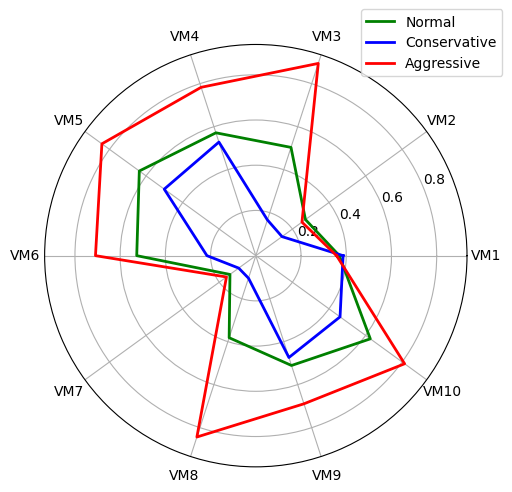

In [ ]:
# Draw radar chart to compare feature patterns across the three driving behavior clusters
categories = ['VM1', 'VM2', 'VM3', 'VM4', 'VM5', 'VM6', 'VM7', 'VM8', 'VM9', 'VM10']
N = len(categories)
categories += [categories[0]]
label_loc = np.linspace(0, 2 * np.pi, N, endpoint=False)
label_loc = np.append(label_loc, label_loc[0])

centers = kmeans.cluster_centers_
clusters_data = [list(center) + [center[0]] for center in centers]

cluster_names = ['Normal', 'Conservative','Aggressive']
colors = ['green', 'blue', 'red']

plt.figure(figsize=(6, 5))
ax = plt.subplot(111, polar=True)

for cluster_values, name, color in zip(clusters_data, cluster_names, colors):
    ax.plot(label_loc, cluster_values, label=name, color=color, linewidth=2)

ax.set_thetagrids(np.degrees(label_loc[:-1]), labels=categories[:-1])
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

In [ ]:
# Create an interactive radar chart of cluster centers using Plotly
import plotly.graph_objects as go
fig = go.Figure()

for cluster_values, name, color in zip(clusters_data, cluster_names, colors):
    fig.add_trace(go.Scatterpolar(
        r=cluster_values,
        theta=categories,
        name=name,
        line=dict(color=color, width=2),
        fill=None
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1]),
        angularaxis=dict(
            direction="clockwise",
            rotation=0
        )
    ),
    showlegend=True,
    title="Cluster Centers Radar Chart",
    width=700,
    height=600
)

fig.show()


In [ ]:
# Remove ID and infrastructure columns from the final dataset
scaled_df0 = final_VM_round.drop(columns=['recordingId','trackId','infrastructure'],axis=1)

In [ ]:
# Print each cluster's center values and number of data points
for i, center in enumerate(centers):
    cluster_points = scaled_df0[clusters == i]  # Select points belonging to the current cluster
    print(f"Cluster {i}: Center = {center}, Number of points = {len(cluster_points)}")

Cluster 0: Center = [0.36935774 0.27143541 0.50351524 0.57138206 0.63699771 0.52676104
 0.14134429 0.38167766 0.51077286 0.62597495], Number of points = 861
Cluster 1: Center = [0.38601399 0.14322972 0.16611185 0.52820643 0.50067904 0.21617821
 0.09359914 0.10476996 0.47366627 0.46050078], Number of points = 1620
Cluster 2: Center = [0.3572881  0.25224874 0.89409692 0.78292457 0.84153339 0.70922637
 0.16053185 0.84344969 0.68897779 0.81349951], Number of points = 378


**0 Normal**

**1 Conservative**

**2 Aggressive**

In [ ]:
# Standardize the scaled VM features using StandardScaler
scaler = StandardScaler()
VM_scaled1 = scaler.fit_transform(df_scaled)

In [ ]:
# Apply PCA to reduce VM features to 2 principal components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(VM_scaled1)
principalDf_round = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
principalDf_round

,principal component 1,principal component 2
0,-0.948310,-1.941649
1,0.771195,-0.417634
2,-1.917903,-1.611283
3,0.177662,-0.991262
4,-2.024722,-1.972942
...,...,...
2854,-2.223184,1.156823
2855,-1.907104,0.615053
2856,-1.002209,0.893347
2857,3.161172,-2.163575


In [ ]:
# Remove infrastructure column and extract cluster labels
combined_df0 = final_VM_round.drop(columns=['infrastructure'],axis=1)
df_label=combined_df0['cluster']

In [ ]:
# Combine PCA components with cluster labels
df_pcl=pd.concat([principalDf_round, df_label], axis=1)

In [ ]:
# Select and keep only data points belonging to cluster 0
df_pcl0=df_pcl.loc[(df_pcl['cluster']==0)]
df_pcl0 = df_pcl0.drop(columns=['cluster'],axis=1)
df_pcl0

,principal component 1,principal component 2
1,0.771195,-0.417634
8,1.225234,-2.060507
10,1.758522,-1.588544
16,0.571435,-3.099070
22,0.523539,-0.666312
...,...,...
2840,0.591014,-2.598835
2842,2.367172,0.868873
2845,1.523459,-0.135765
2848,1.362417,-0.482454


In [ ]:
# Select and keep only data points belonging to cluster 1
df_pcl1=df_pcl.loc[(df_pcl['cluster']==1)]
df_pcl1 = df_pcl1.drop(columns=['cluster'],axis=1)
df_pcl1

,principal component 1,principal component 2
0,-0.948310,-1.941649
2,-1.917903,-1.611283
3,0.177662,-0.991262
4,-2.024722,-1.972942
9,-0.926088,-1.966967
...,...,...
2852,-1.668480,1.409465
2853,-1.201679,-0.147781
2854,-2.223184,1.156823
2855,-1.907104,0.615053


In [ ]:
# Select and keep only data points belonging to cluster 2
df_pcl2=df_pcl.loc[(df_pcl['cluster']==2)]
df_pcl2 = df_pcl2.drop(columns=['cluster'],axis=1)
df_pcl2

,principal component 1,principal component 2
5,3.302592,-0.938110
6,4.329536,-1.717587
7,3.114581,-3.706810
12,6.172892,-0.273293
13,4.256669,-1.495204
...,...,...
2816,5.183790,0.136878
2823,3.498491,-0.774154
2825,2.696220,-1.870595
2843,2.333077,-0.961042


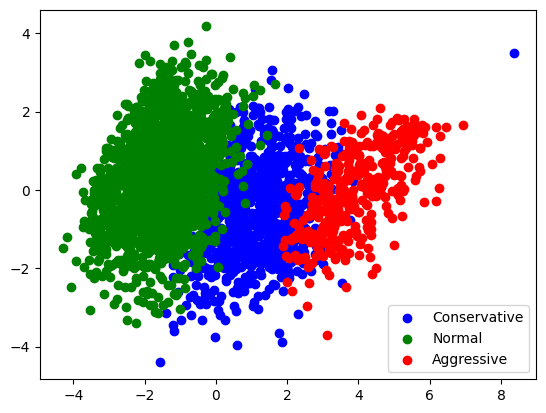

In [ ]:
plt.scatter(df_pcl0['principal component 1'], df_pcl0['principal component 2'], c='blue', label='Conservative')
plt.scatter(df_pcl1['principal component 1'], df_pcl1['principal component 2'], c='green', label='Normal')
plt.scatter(df_pcl2['principal component 1'], df_pcl2['principal component 2'], c='red', label='Aggressive')

plt.legend()
plt.savefig('cluters.png', dpi=600)
plt.show()

In [ ]:
# Visualize PCA results with clusters using an interactive scatter plot
import plotly.express as px

df_pca_all = pd.concat([
    df_pcl0.assign(cluster='Conservative'),
    df_pcl1.assign(cluster='Normal'),
    df_pcl2.assign(cluster='Aggressive')
])

fig = px.scatter(
    df_pca_all,
    x='principal component 1',
    y='principal component 2',
    color='cluster',
    title='PCA Clusters Visualization',
    color_discrete_map={
        'Conservative': 'blue',
        'Normal': 'green',
        'Aggressive': 'red'
    },
    hover_data=df_pca_all.columns
)

fig.update_layout(
    template='plotly_white',
    title_font_size=18,
    legend_title_text='Driving Style',
    legend=dict(x=0.9, y=0.9)
)

fig.show()

In [ ]:
# Add driver behavior labels and remove VM feature columns
Drive_Behavior_round = final_VM_round.copy()
Drive_Behavior_round['Driver Behavior'] = Drive_Behavior_round['cluster'].map({0: 'Conservative', 1: 'Normal', 2: 'Aggressive'})
Drive_Behavior_round.drop(columns=['VM1','VM2','VM3','VM4','VM5','VM6','VM7','VM8','VM9','VM10'], inplace=True)
Drive_Behavior_round

,recordingId,trackId,infrastructure,cluster,Driver Behavior
0,0,24,roundabout,1,Normal
1,0,28,roundabout,0,Conservative
2,0,30,roundabout,1,Normal
3,0,34,roundabout,1,Normal
4,0,39,roundabout,1,Normal
...,...,...,...,...,...
2854,23,437,roundabout,1,Normal
2855,23,440,roundabout,1,Normal
2856,23,446,roundabout,1,Normal
2857,23,452,roundabout,2,Aggressive


# Fuel consumption Roundabout

In [ ]:
df_original_round

,recordingId,trackId,lonVelocity,lonAcceleration,xCenter,yCenter,frame,xAcceleration
0,7,14,7.8720,0.9321,98.4698,-59.3441,0,-1.8095
1,7,14,7.9325,0.9590,98.6169,-59.0661,1,-1.8666
2,7,14,7.9940,0.9725,98.7636,-58.7817,2,-1.9308
3,7,14,8.0552,0.9731,98.9081,-58.4918,3,-2.0014
4,7,14,8.1151,0.9622,99.0507,-58.1971,4,-2.0775
...,...,...,...,...,...,...,...,...
1091894,9,709,7.0678,1.9155,100.4789,-38.7617,26743,-1.5455
1091895,9,709,7.1442,1.9167,100.2909,-38.5480,26744,-1.5465
1091896,9,709,7.2205,1.9180,100.1003,-38.3327,26745,-1.5469
1091897,9,709,7.2967,1.9192,99.9074,-38.1156,26746,-1.5470


In [ ]:
# Calculate distance between consecutive points in kilometers
df_original_round['distance'] = np.sqrt((df_original_round['xCenter'].diff())**2 + (df_original_round['yCenter'].diff())**2) / 1000

In [ ]:
# Calculate total fuel consumption per driver using motion and standby formulas
df_original_round["dt"] = 1.0 / 25
def calculateFCma(vel):
    return (217. + 0.253 * vel + 0.00965 * vel ** 2) / (1 + 0.096 * vel - 0.000421 * vel ** 2)


def calculateFCsa(dt):
    return 0.361 * dt

def calculateFCtotal(vector):
    FCma = calculateFCma(vector['lonVelocity'])
    FCsa = calculateFCsa(vector['dt'])

    FCtotal = np.where(vector['lonVelocity'] >= 4.5, FCma * vector['distance'], FCsa * 0.77)
    return FCtotal.sum()

fc_per_driver_round = df_original_round.groupby(["recordingId", "trackId"]).apply(calculateFCtotal).reset_index(name="FuelConsumption")
fc_per_driver_round

/tmp/ipython-input-2860158518.py:17: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,recordingId,trackId,FuelConsumption
0,0,24,20.834767
1,0,28,27.911170
2,0,30,14.754914
3,0,34,23.684922
4,0,39,26.496437
...,...,...,...
2995,23,440,20.412825
2996,23,446,19.488055
2997,23,452,12.402575
2998,23,459,10.724510


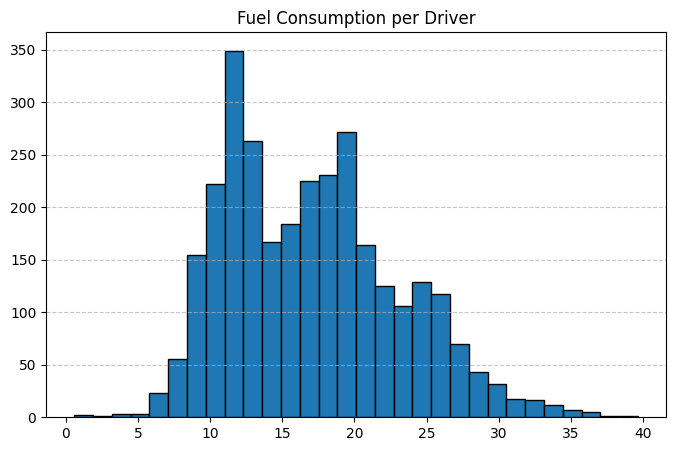

In [ ]:
# Plot histogram of fuel consumption per driver
plt.figure(figsize=(8, 5))
plt.hist(fc_per_driver_round['FuelConsumption'], bins=30, edgecolor='black')
plt.title('Fuel Consumption per Driver')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Vehicle emissions on roundabouts

**in a progress**

# Intersection

In [ ]:
# Check if the folder exists and get all CSV files from the 'datainD' directory
folder_path_ins = Path("/content/drive/MyDrive/FC Research/datainD")
if folder_path_ins.exists():
    csv_files_ins = [file.as_posix() for file in folder_path_ins.iterdir() if file.is_file() and file.suffix == ".csv"]
else:
    csv_files_ins = []
    print("Folder does not exist!")
csv_files_ins

['/content/drive/MyDrive/FC Research/datainD/01_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/29_tracksMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/29_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/21_tracksMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/30_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/18_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/04_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/00_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/26_tracksMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/28_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/31_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/27_tracksMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/19_recordingMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/32_tracksMeta.csv',
 '/content/drive/MyDrive/FC Research/datainD/28_tracksMeta.csv'

In [ ]:
# Load, merge, and clean car-related data from 'inD' dataset CSV files
meta_files = list(folder_path_ins.glob("*_tracksMeta.csv"))
tracks_files = list(folder_path_ins.glob("*_tracks.csv"))
recording_files = list(folder_path_ins.glob("*_recordingMeta.csv"))

meta_list = []
for file in meta_files:
    df_meta = pd.read_csv(file)
    if "class" in df_meta.columns:
        df_meta = df_meta[df_meta["class"] == "car"]
        meta_list.append(df_meta[["recordingId", "trackId", "class"]])

cars_meta = pd.concat(meta_list, ignore_index=True)

tracks_list = []
for file in tracks_files:
    df_tracks = pd.read_csv(file)
    tracks_list.append(df_tracks)

tracks = pd.concat(tracks_list, ignore_index=True)

cars_tracks_ins = tracks.merge(cars_meta, on=["recordingId", "trackId"], how="inner")

rec_list = []
for file in recording_files:
    df_rec = pd.read_csv(file)
    rec_list.append(df_rec)

recording_meta = pd.concat(rec_list, ignore_index=True)

cars_tracks_ins = cars_tracks_ins.merge(recording_meta, on="recordingId", how="left")

col_list = ["recordingId","trackId","lonVelocity","lonAcceleration","xCenter","yCenter","frame","xAcceleration"]
cars_tracks_ins = cars_tracks_ins[col_list].dropna()
cars_tracks_ins

,recordingId,trackId,lonVelocity,lonAcceleration,xCenter,yCenter,frame,xAcceleration
0,7,0,9.65238,1.97928,49.08017,-24.74120,0,-1.50784
1,7,0,9.75219,1.98841,48.83219,-24.44429,1,-1.51208
2,7,0,9.85150,1.97730,48.57888,-24.14266,2,-1.49979
3,7,0,9.94852,1.94733,48.32055,-23.83694,3,-1.47211
4,7,0,10.04199,1.90061,48.05787,-23.52818,4,-1.43086
...,...,...,...,...,...,...,...,...
10614545,9,234,7.08804,1.13319,66.42260,-21.78462,19543,1.68292
10614546,9,234,7.13476,1.14147,66.59356,-21.55744,19544,1.68216
10614547,9,234,7.18191,1.14962,66.76725,-21.33002,19545,1.68191
10614548,9,234,7.22943,1.15771,66.94423,-21.10244,19546,1.68186


In [ ]:
# Sample up to 3000 unique vehicles and create a filtered inD dataset
unique_vehicles = cars_tracks_ins[['recordingId', 'trackId']].drop_duplicates()
sample_size = min(3000, len(unique_vehicles))
sample_vehicles = unique_vehicles.sample(n=sample_size, random_state=42)
df_original_ins = cars_tracks_ins.merge(sample_vehicles, on=['recordingId', 'trackId'], how='inner')
df_original_ins = df_original_ins[['recordingId','trackId','lonVelocity','lonAcceleration','xCenter','yCenter','frame','xAcceleration']]
df_original_ins

,recordingId,trackId,lonVelocity,lonAcceleration,xCenter,yCenter,frame,xAcceleration
0,7,0,9.65238,1.97928,49.08017,-24.74120,0,-1.50784
1,7,0,9.75219,1.98841,48.83219,-24.44429,1,-1.51208
2,7,0,9.85150,1.97730,48.57888,-24.14266,2,-1.49979
3,7,0,9.94852,1.94733,48.32055,-23.83694,3,-1.47211
4,7,0,10.04199,1.90061,48.05787,-23.52818,4,-1.43086
...,...,...,...,...,...,...,...,...
3530253,9,229,10.38944,1.11482,74.32355,-56.60689,18978,0.59928
3530254,9,229,10.43481,1.11587,74.59518,-56.92239,18979,0.59828
3530255,9,229,10.47993,1.11619,74.86781,-57.24058,18980,0.59791
3530256,9,229,10.52471,1.11620,75.14120,-57.56071,18981,0.59784


In [ ]:
# Count and display the number of unique drivers in the inD dataset
num_drivers = df_original_ins[['recordingId', 'trackId']].drop_duplicates().shape[0]
print("Number of Drivers", num_drivers)

Number of Drivers 3000


In [ ]:
# calculate VM1
VMI1 = (df_original_ins.groupby(['recordingId','trackId']).agg(VM1=('xAcceleration', 'std')).reset_index())
VMI1

,recordingId,trackId,VM1
0,0,2,0.293128
1,0,5,0.000000
2,0,7,0.714217
3,0,8,0.460605
4,0,9,0.616638
...,...,...,...
2995,32,457,0.481573
2996,32,458,1.666522
2997,32,462,1.567028
2998,32,464,0.713669


In [ ]:
#calculate VM2
VMI2 = df_original_ins.groupby(['recordingId','trackId']).agg(VM2=('lonAcceleration', 'std')).reset_index()
VMI2

,recordingId,trackId,VM2
0,0,2,0.433014
1,0,5,0.000000
2,0,7,1.312506
3,0,8,0.468322
4,0,9,0.555989
...,...,...,...
2995,32,457,0.675027
2996,32,458,1.861522
2997,32,462,1.556761
2998,32,464,0.608007


In [ ]:
#calculate VM3
df_VMI3=df_original_ins.groupby(['recordingId','trackId']).agg(avgV=('lonVelocity','mean'),stdV=('lonVelocity', 'std'))
df_VMI3['VM3']=100*df_VMI3['stdV']/df_VMI3['avgV']
df_VMI3=df_VMI3[['VM3']].reset_index()
df_VMI3

,recordingId,trackId,VM3
0,0,2,14.884878
1,0,5,NaN
2,0,7,85.915008
3,0,8,2.010723
4,0,9,4.718411
...,...,...,...
2995,32,457,2.177977
2996,32,458,78.485630
2997,32,462,28.320852
2998,32,464,23.053479


In [ ]:
#calculate VM4
filtered_accel_df = df_original_ins[df_original_ins['lonAcceleration'] >= 0]
df_VMI4 = (filtered_accel_df.groupby(['recordingId','trackId']).agg(avgA=('lonAcceleration','mean'),stdA=('lonAcceleration','std')))
df_VMI4['VM4'] = 100 * df_VMI4['stdA'] / df_VMI4['avgA']
df_VMI4 = df_VMI4[['VM4']].reset_index()
df_VMI4

,recordingId,trackId,VM4
0,0,2,32.604863
1,0,5,NaN
2,0,7,49.221343
3,0,8,111.101144
4,0,9,70.082761
...,...,...,...
2993,32,457,121.858129
2994,32,458,53.511966
2995,32,462,40.741056
2996,32,464,53.308180


In [ ]:
#calculate VM5
filtered_decel_df = df_original_ins[df_original_ins['lonAcceleration'] < 0]
df_VMI5 = (filtered_decel_df.groupby(['recordingId','trackId']).agg(avgD=('lonAcceleration','mean'),stdD=('lonAcceleration','std')))
df_VMI5['VM5'] = 100 * df_VMI5['stdD'] / df_VMI5['avgD'].abs()
df_VMI5 = df_VMI5[['VM5']].reset_index()
df_VMI5

,recordingId,trackId,VM5
0,0,7,89.423523
1,0,8,67.878034
2,0,9,28.682809
3,0,10,66.585718
4,0,14,57.308367
...,...,...,...
2671,32,457,54.133514
2672,32,458,73.944496
2673,32,462,42.443816
2674,32,464,46.612978


In [ ]:
#calculate VM6
df_VMI6 = df_original_ins.groupby(['recordingId', 'trackId']).agg(VM6=('lonVelocity', calculate_mad)).reset_index()
df_VMI6

,recordingId,trackId,VM6
0,0,2,1.573135
1,0,5,0.000000
2,0,7,3.831687
3,0,8,0.188092
4,0,9,0.587330
...,...,...,...
2995,32,457,0.221788
2996,32,458,2.888988
2997,32,462,1.152934
2998,32,464,1.254518


In [ ]:
#calculate VM7
filtered_accel_df = df_original_ins[df_original_ins['lonAcceleration'] >= 0]
VMI7 = filtered_accel_df.groupby(['recordingId', 'trackId']).agg(VM7=('lonAcceleration', calculate_mad)).reset_index()
VMI7

,recordingId,trackId,VM7
0,0,2,0.255984
1,0,5,0.000000
2,0,7,0.459956
3,0,8,0.451851
4,0,9,0.286773
...,...,...,...
2993,32,457,0.664628
2994,32,458,0.488005
2995,32,462,0.365087
2996,32,464,0.195643


In [ ]:
#calculate VM8
df_VMI8 = df_original_ins.groupby(['recordingId','trackId']).agg(q1_speed=('lonVelocity', q1),q3_speed=('lonVelocity', q3)).reset_index()
df_VMI8['VM8'] = 100 * (df_VMI8['q3_speed'] - df_VMI8['q1_speed']) / (df_VMI8['q3_speed'] + df_VMI8['q1_speed'])
df_VMI8 = df_VMI8[['recordingId','trackId','VM8']]
df_VMI8

,recordingId,trackId,VM8
0,0,2,11.865855
1,0,5,NaN
2,0,7,85.102289
3,0,8,1.020589
4,0,9,3.076738
...,...,...,...
2995,32,457,1.477581
2996,32,458,78.250596
2997,32,462,23.038777
2998,32,464,20.593378


In [ ]:
#calculate VM9
filtered_accel_df = df_original_ins[df_original_ins['lonAcceleration'] >= 0]
df_VMI9 = filtered_accel_df.groupby(['recordingId','trackId']).agg(q1_acc=('lonAcceleration', q1),q3_acc=('lonAcceleration', q3)).reset_index()
df_VMI9['VM9'] = 100 * (df_VMI9['q3_acc'] - df_VMI9['q1_acc']) / (df_VMI9['q3_acc'] + df_VMI9['q1_acc'])
df_VMI9 = df_VMI9[['recordingId','trackId','VM9']]
df_VMI9

,recordingId,trackId,VM9
0,0,2,2.986709
1,0,5,NaN
2,0,7,34.886245
3,0,8,88.181663
4,0,9,55.902911
...,...,...,...
2993,32,457,85.685113
2994,32,458,35.511487
2995,32,462,28.569076
2996,32,464,40.371941


In [ ]:
#calculate VM10
filtered_accel_df = df_original_ins[df_original_ins['lonAcceleration'] < 0]
df_VMI10 = filtered_accel_df.groupby(['recordingId', 'trackId'])['lonAcceleration'].agg([q1, q3, 'max'])
VMI10_1 = 100 * abs(df_VMI10['q3'] - df_VMI10['q1']) / abs(df_VMI10['q3'] + df_VMI10['q1'])
VMI10 = VMI10_1.to_frame(name='VM10')
VMI10

VM10
recordingId trackId           
0           7        78.842383
            8        45.328879
            9         8.052466
            10       61.563434
            14       53.235221
...                        ...
32          457      48.451851
            458      81.639657
            462      34.854290
            464      40.770668
            465      43.830227

[2676 rows x 1 columns]

In [ ]:
# Merge all VMI dataframes and label the infrastructure type as 'intersection'
pdList = [VMI1, VMI2, df_VMI3, df_VMI4, df_VMI5, df_VMI6, VMI7, df_VMI8, df_VMI9, VMI10]  # List of your dataframes
final_df = reduce(lambda left, right: pd.merge(left, right, on=['recordingId', 'trackId'], how='inner'), pdList)
final_df['infrastructure'] = 'intersection'
final_VM_ins = final_df.copy()
final_VM_ins

,recordingId,trackId,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10,infrastructure
0,0,7,0.714217,1.312506,85.915008,49.221343,89.423523,3.831687,0.459956,85.102289,34.886245,78.842383,intersection
1,0,8,0.460605,0.468322,2.010723,111.101144,67.878034,0.188092,0.451851,1.020589,88.181663,45.328879,intersection
2,0,9,0.616638,0.555989,4.718411,70.082761,28.682809,0.587330,0.286773,3.076738,55.902911,8.052466,intersection
3,0,10,0.507706,0.567145,5.687633,76.783384,66.585718,0.786176,0.301450,5.368410,50.335897,61.563434,intersection
4,0,14,1.305663,1.418080,3.765643,82.047172,57.308367,0.632870,0.348389,2.293733,27.609382,53.235221,intersection
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,32,457,0.481573,0.675027,2.177977,121.858129,54.133514,0.221788,0.664628,1.477581,85.685113,48.451851,intersection
2670,32,458,1.666522,1.861522,78.485630,53.511966,73.944496,2.888988,0.488005,78.250596,35.511487,81.639657,intersection
2671,32,462,1.567028,1.556761,28.320852,40.741056,42.443816,1.152934,0.365087,23.038777,28.569076,34.854290,intersection
2672,32,464,0.713669,0.608007,23.053479,53.308180,46.612978,1.254518,0.195643,20.593378,40.371941,40.770668,intersection


In [ ]:
# Display summary statistics for the intersection dataset
final_VM_ins.describe()

,recordingId,trackId,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10
count,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2672.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000
mean,16.712790,214.978310,0.626421,0.738591,20.353295,78.639913,62.600551,1.176967,0.383784,25.639398,52.220035,48.678948
std,10.169926,134.053326,0.291702,0.358590,580.421415,37.643470,27.245327,0.907440,0.169351,54.915918,21.994184,22.029365
min,0.000000,0.000000,0.091222,0.114751,-29882.819692,23.313102,15.471784,0.041109,0.004862,-863.742690,4.794935,0.000000
25%,8.000000,104.000000,0.397725,0.456967,3.497634,52.578665,45.248315,0.382960,0.256752,2.629132,36.328527,32.741002
50%,17.000000,202.000000,0.558429,0.655169,16.494905,67.056532,56.542965,0.992729,0.370806,13.545003,50.294194,45.791885
75%,26.000000,310.000000,0.800983,0.971717,43.375643,96.300503,73.480470,1.777467,0.495771,35.775277,65.987419,63.515118
max,32.000000,607.000000,2.097471,2.261853,870.368438,456.671186,356.012915,5.591211,1.558959,1956.607280,100.000000,99.435116


**outlier handling**

In [ ]:
# Clip VM feature values to the 1st–99th percentile range to reduce outliers
vm_cols = ['VM1','VM2','VM3','VM4','VM5','VM6','VM7','VM8','VM9','VM10']
df_clean = final_VM_ins.copy()

for col in vm_cols:
    lower = df_clean[col].quantile(0.01)
    upper = df_clean[col].quantile(0.99)
    df_clean[col] = np.where(df_clean[col] < lower, lower, df_clean[col])
    df_clean[col] = np.where(df_clean[col] > upper, upper, df_clean[col])

# k_means clustering Intersection

In [ ]:
# Remove ID columns and check for missing values in the intersection dataset
VM_ins=(df_clean.drop(['recordingId','trackId','infrastructure'],axis=1))
VM_ins.isnull().sum()

,0
VM1,0
VM2,0
VM3,0
VM4,0
VM5,2
VM6,0
VM7,0
VM8,0
VM9,0
VM10,0


In [ ]:
# Fill missing values in VM5 with the column mean
VM_ins['VM5'].fillna(VM_ins['VM5'].mean(), inplace=True)

/tmp/ipython-input-1777956717.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
VM_ins

,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10
0,0.714217,1.312506,85.915008,49.221343,89.423523,3.831687,0.459956,85.102289,34.886245,78.842383
1,0.460605,0.468322,2.010723,111.101144,67.878034,0.188092,0.451851,1.020589,88.181663,45.328879
2,0.616638,0.555989,4.718411,70.082761,28.682809,0.587330,0.286773,3.076738,55.902911,8.614215
3,0.507706,0.567145,5.687633,76.783384,66.585718,0.786176,0.301450,5.368410,50.335897,61.563434
4,1.305663,1.418080,3.765643,82.047172,57.308367,0.632870,0.348389,2.293733,27.609382,53.235221
...,...,...,...,...,...,...,...,...,...,...
2669,0.481573,0.675027,2.177977,121.858129,54.133514,0.221788,0.664628,1.477581,85.685113,48.451851
2670,1.482240,1.803446,78.485630,53.511966,73.944496,2.888988,0.488005,78.250596,35.511487,81.639657
2671,1.482240,1.556761,28.320852,40.741056,42.443816,1.152934,0.365087,23.038777,28.569076,34.854290
2672,0.713669,0.608007,23.053479,53.308180,46.612978,1.254518,0.195643,20.593378,40.371941,40.770668


In [ ]:
# VM_ins = VM_ins.reset_index(drop=True)
# final_VM_ins = final_VM_ins.reset_index(drop=True)

In [ ]:
# Scale intersection dataset features between 0 and 1 using Min-Max scaling
scaler = MinMaxScaler()
VM_scaledI = scaler.fit_transform(VM_ins)

In [ ]:
# Apply K-Means clustering with 3 clusters on the intersection dataset
kmeansI = KMeans(n_clusters=3, random_state=42)
kmeansI.fit(VM_scaledI)
clustersI = kmeansI.labels_

In [ ]:
# Add cluster labels to the final intersection dataset
final_VM_ins = final_VM_ins.loc[VM_ins.index]
final_VM_ins['cluster'] = clustersI
final_VM_ins

,recordingId,trackId,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10,infrastructure,cluster
0,0,7,0.714217,1.312506,85.915008,49.221343,89.423523,3.831687,0.459956,85.102289,34.886245,78.842383,intersection,1
1,0,8,0.460605,0.468322,2.010723,111.101144,67.878034,0.188092,0.451851,1.020589,88.181663,45.328879,intersection,2
2,0,9,0.616638,0.555989,4.718411,70.082761,28.682809,0.587330,0.286773,3.076738,55.902911,8.052466,intersection,2
3,0,10,0.507706,0.567145,5.687633,76.783384,66.585718,0.786176,0.301450,5.368410,50.335897,61.563434,intersection,2
4,0,14,1.305663,1.418080,3.765643,82.047172,57.308367,0.632870,0.348389,2.293733,27.609382,53.235221,intersection,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,32,457,0.481573,0.675027,2.177977,121.858129,54.133514,0.221788,0.664628,1.477581,85.685113,48.451851,intersection,2
2670,32,458,1.666522,1.861522,78.485630,53.511966,73.944496,2.888988,0.488005,78.250596,35.511487,81.639657,intersection,0
2671,32,462,1.567028,1.556761,28.320852,40.741056,42.443816,1.152934,0.365087,23.038777,28.569076,34.854290,intersection,0
2672,32,464,0.713669,0.608007,23.053479,53.308180,46.612978,1.254518,0.195643,20.593378,40.371941,40.770668,intersection,0


In [ ]:
centersI = kmeansI.cluster_centers_

In [ ]:
print(centersI)

[[0.51343951 0.51828522 0.20694808 0.15685988 0.26888634 0.44157456
  0.43345937 0.31452997 0.36661655 0.43625088]
 [0.44320308 0.4322044  0.6193015  0.39853281 0.60106823 0.58811215
  0.56796108 0.88917034 0.76253993 0.81803182]
 [0.16582774 0.15223374 0.03439816 0.39048993 0.24055375 0.10977104
  0.3554133  0.04981284 0.49755546 0.37283911]]


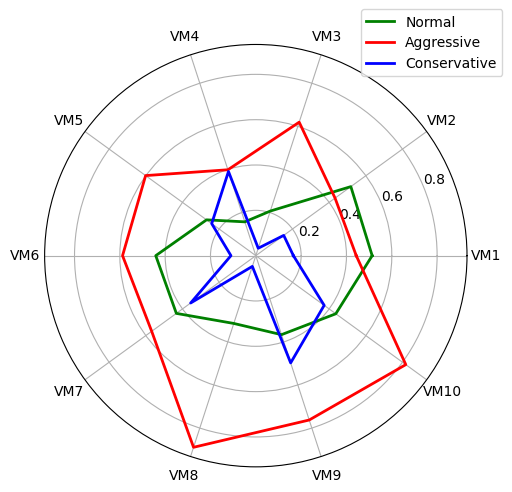

In [ ]:
# Plot radar chart comparing cluster feature profiles for the intersection dataset
categories = ['VM1', 'VM2', 'VM3', 'VM4', 'VM5', 'VM6', 'VM7', 'VM8', 'VM9', 'VM10']
N = len(categories)
categories += [categories[0]]
label_loc = np.linspace(0, 2 * np.pi, N, endpoint=False)
label_loc = np.append(label_loc, label_loc[0])

clusters_data = [list(center) + [center[0]] for center in centersI]

cluster_names = ['Normal', 'Aggressive', 'Conservative']
colors = ['green', 'red', 'blue']

plt.figure(figsize=(6, 5))
ax = plt.subplot(111, polar=True)

for cluster_values, name, color in zip(clusters_data, cluster_names, colors):
    ax.plot(label_loc, cluster_values, label=name, color=color, linewidth=2)

ax.set_thetagrids(np.degrees(label_loc[:-1]), labels=categories[:-1])
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()


In [ ]:
fig = go.Figure()

for cluster_values, name, color in zip(clusters_data, cluster_names, colors):
    fig.add_trace(go.Scatterpolar(
        r=cluster_values,
        theta=categories,
        name=name,
        line=dict(color=color, width=2),
        fill=None
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1]),
        angularaxis=dict(
            direction="clockwise",
            rotation=0
        )
    ),
    showlegend=True,
    title="Cluster Centers Radar Chart",
    width=700,
    height=600
)

fig.show()

In [ ]:
# Remove ID and infrastructure columns from the intersection dataset
scaled_df0I = final_VM_ins.drop(columns=['recordingId','trackId','infrastructure'],axis=1)

In [ ]:
for i, center in enumerate(centersI):
    cluster_points = scaled_df0I[clustersI == i]  # Select points belonging to the current cluster
    print(f"Cluster {i}: Center = {center}, Number of points = {len(cluster_points)}")

Cluster 0: Center = [0.51343951 0.51828522 0.20694808 0.15685988 0.26888634 0.44157456
 0.43345937 0.31452997 0.36661655 0.43625088], Number of points = 967
Cluster 1: Center = [0.44320308 0.4322044  0.6193015  0.39853281 0.60106823 0.58811215
 0.56796108 0.88917034 0.76253993 0.81803182], Number of points = 315
Cluster 2: Center = [0.16582774 0.15223374 0.03439816 0.39048993 0.24055375 0.10977104
 0.3554133  0.04981284 0.49755546 0.37283911], Number of points = 1392


**0 Normal**

**1 Aggressive**

**2 Conservative**

In [ ]:
# Standardize intersection dataset features using StandardScaler
scaler = StandardScaler()
VM_scaledI1 = scaler.fit_transform(VM_ins)

In [ ]:
# Apply PCA to reduce intersection dataset features to 2 principal components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(VM_scaledI1)
principalDf_ins = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
principalDf_ins

,principal component 1,principal component 2
0,4.187864,-0.875167
1,-1.334402,1.810008
2,-2.066178,-0.994640
3,-0.942845,0.445717
4,0.415070,-1.818363
...,...,...
2669,-0.940809,1.572880
2670,4.868599,-2.043621
2671,1.302609,-3.212978
2672,-0.674841,-1.032345


In [ ]:
# Remove infrastructure column and extract cluster labels for the intersection dataset
combined_df0I= final_VM_ins.drop(columns=['infrastructure'],axis=1)
df_labelI=combined_df0I['cluster']

In [ ]:
# Combine PCA components with cluster labels for the intersection dataset
df_pclI=pd.concat([principalDf_ins, df_labelI], axis=1)

In [ ]:
df_pclI

,principal component 1,principal component 2,cluster
0,4.187864,-0.875167,1
1,-1.334402,1.810008,2
2,-2.066178,-0.994640,2
3,-0.942845,0.445717,2
4,0.415070,-1.818363,0
...,...,...,...
2669,-0.940809,1.572880,2
2670,4.868599,-2.043621,0
2671,1.302609,-3.212978,0
2672,-0.674841,-1.032345,0


In [ ]:
# Combine PCA components with cluster labels for the intersection dataset
df_pcl0I=df_pclI.loc[(df_pclI['cluster']==0)]
df_pcl0I = df_pcl0I.drop(columns=['cluster'],axis=1)
df_pcl0I

,principal component 1,principal component 2
4,0.415070,-1.818363
12,3.326411,-2.388888
13,1.629803,-1.936231
21,3.045094,-2.582008
22,2.642203,-2.978071
...,...,...
2668,-0.179538,-0.635941
2670,4.868599,-2.043621
2671,1.302609,-3.212978
2672,-0.674841,-1.032345


In [ ]:
# Select and keep only data points belonging to cluster 1 in the intersection dataset
df_pcl1I=df_pclI.loc[(df_pclI['cluster']==1)]
df_pcl1I = df_pcl1I.drop(columns=['cluster'],axis=1)
df_pcl1I

,principal component 1,principal component 2
0,4.187864,-0.875167
6,4.025464,-0.648053
15,3.990169,0.571310
18,2.484713,-0.189353
46,4.362979,-0.179081
...,...,...
2619,3.324939,-0.413169
2625,4.863024,4.259978
2650,4.605270,4.751473
2651,4.046256,4.510913


In [ ]:
# Select and keep only data points belonging to cluster 2 in the intersection dataset
df_pcl2I=df_pclI.loc[(df_pclI['cluster']==2)]
df_pcl2I = df_pcl2I.drop(columns=['cluster'],axis=1)
df_pcl2I

,principal component 1,principal component 2
1,-1.334402,1.810008
2,-2.066178,-0.994640
3,-0.942845,0.445717
5,-3.043749,-0.243496
7,-2.287968,1.749685
...,...,...
2664,-1.073814,-1.772946
2665,-2.108441,0.013387
2666,-1.215947,1.618512
2667,-1.091472,2.090005


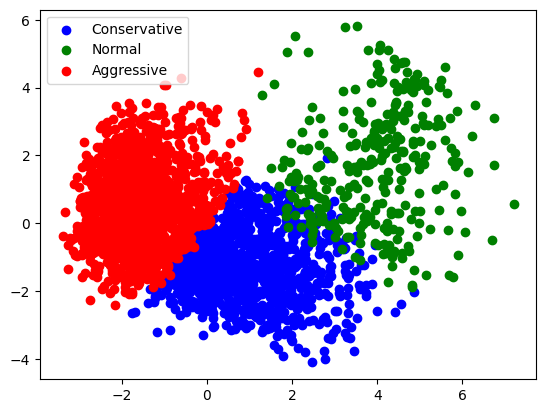

In [ ]:
# Plot PCA scatter chart showing the three driving behavior clusters
plt.scatter(df_pcl0I['principal component 1'], df_pcl0I['principal component 2'], c='blue', label='Conservative')
plt.scatter(df_pcl1I['principal component 1'], df_pcl1I['principal component 2'], c='green', label='Normal')
plt.scatter(df_pcl2I['principal component 1'], df_pcl2I['principal component 2'], c='red', label='Aggressive')

plt.legend()
plt.savefig('cluters.png', dpi=600)
plt.show()

In [ ]:

df_pca_all = pd.concat([
    df_pcl0I.assign(cluster='Conservative'),
    df_pcl1I.assign(cluster='Normal'),
    df_pcl2I.assign(cluster='Aggressive')
])

fig = px.scatter(
    df_pca_all,
    x='principal component 1',
    y='principal component 2',
    color='cluster',
    title='PCA Clusters Visualization',
    color_discrete_map={
        'Conservative': 'blue',
        'Normal': 'green',
        'Aggressive': 'red'
    },
    hover_data=df_pca_all.columns
)

fig.update_layout(
    template='plotly_white',
    title_font_size=18,
    legend_title_text='Driving Style',
    legend=dict(x=0.9, y=0.9)
)

fig.show()

In [ ]:
final_VM_ins

,recordingId,trackId,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10,infrastructure,cluster
0,0,7,0.714217,1.312506,85.915008,49.221343,89.423523,3.831687,0.459956,85.102289,34.886245,78.842383,intersection,1
1,0,8,0.460605,0.468322,2.010723,111.101144,67.878034,0.188092,0.451851,1.020589,88.181663,45.328879,intersection,2
2,0,9,0.616638,0.555989,4.718411,70.082761,28.682809,0.587330,0.286773,3.076738,55.902911,8.052466,intersection,2
3,0,10,0.507706,0.567145,5.687633,76.783384,66.585718,0.786176,0.301450,5.368410,50.335897,61.563434,intersection,2
4,0,14,1.305663,1.418080,3.765643,82.047172,57.308367,0.632870,0.348389,2.293733,27.609382,53.235221,intersection,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,32,457,0.481573,0.675027,2.177977,121.858129,54.133514,0.221788,0.664628,1.477581,85.685113,48.451851,intersection,2
2670,32,458,1.666522,1.861522,78.485630,53.511966,73.944496,2.888988,0.488005,78.250596,35.511487,81.639657,intersection,0
2671,32,462,1.567028,1.556761,28.320852,40.741056,42.443816,1.152934,0.365087,23.038777,28.569076,34.854290,intersection,0
2672,32,464,0.713669,0.608007,23.053479,53.308180,46.612978,1.254518,0.195643,20.593378,40.371941,40.770668,intersection,0


In [ ]:
# Add driver behavior labels and remove VM feature and infrastructure columns
Drive_Behavior_ins = final_VM_ins.copy()
Drive_Behavior_ins['Driver Behavior'] = Drive_Behavior_ins['cluster'].map({0: 'Normal', 1: 'Conservative', 2: 'Aggressive'})
Drive_Behavior_ins.drop(columns=['VM1','VM2','VM3','VM4','VM5','VM6','VM7','VM8','VM9','VM10','infrastructure'], inplace=True)
Drive_Behavior_ins

,recordingId,trackId,cluster,Driver Behavior
0,0,7,1,Conservative
1,0,8,2,Aggressive
2,0,9,2,Aggressive
3,0,10,2,Aggressive
4,0,14,0,Normal
...,...,...,...,...
2669,32,457,2,Aggressive
2670,32,458,0,Normal
2671,32,462,0,Normal
2672,32,464,0,Normal


# Fuel consumption Intersection-

In [ ]:
df_original_ins

,recordingId,trackId,lonVelocity,lonAcceleration,xCenter,yCenter,frame,xAcceleration
0,7,0,9.65238,1.97928,49.08017,-24.74120,0,-1.50784
1,7,0,9.75219,1.98841,48.83219,-24.44429,1,-1.51208
2,7,0,9.85150,1.97730,48.57888,-24.14266,2,-1.49979
3,7,0,9.94852,1.94733,48.32055,-23.83694,3,-1.47211
4,7,0,10.04199,1.90061,48.05787,-23.52818,4,-1.43086
...,...,...,...,...,...,...,...,...
3530253,9,229,10.38944,1.11482,74.32355,-56.60689,18978,0.59928
3530254,9,229,10.43481,1.11587,74.59518,-56.92239,18979,0.59828
3530255,9,229,10.47993,1.11619,74.86781,-57.24058,18980,0.59791
3530256,9,229,10.52471,1.11620,75.14120,-57.56071,18981,0.59784


In [ ]:
# Calculate distance between consecutive points in kilometers for the intersection dataset
df_original_ins['distance'] = np.sqrt((df_original_ins['xCenter'].diff())**2 + (df_original_ins['yCenter'].diff())**2) / 1000

In [ ]:
# Calculate total fuel consumption per driver for the intersection dataset
df_original_ins["dt"] = 1.0 / 25
def calculateFCma(vel):
    return (217. + 0.253 * vel + 0.00965 * vel ** 2) / (1 + 0.096 * vel - 0.000421 * vel ** 2)


def calculateFCsa(dt):
    return 0.361 * dt

def calculateFCtotal(vector):
    FCma = calculateFCma(vector['lonVelocity'])
    FCsa = calculateFCsa(vector['dt'])

    FCtotal = np.where(vector['lonVelocity'] >= 4.5, FCma * vector['distance'], FCsa * 0.77)
    return FCtotal.sum()

fc_per_driver_ins = df_original_ins.groupby(["recordingId", "trackId"]).apply(calculateFCtotal).reset_index(name="FuelConsumption")
fc_per_driver_ins

/tmp/ipython-input-991124471.py:17: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,recordingId,trackId,FuelConsumption
0,0,2,12.763358
1,0,5,267.151408
2,0,7,19.280388
3,0,8,26.444751
4,0,9,25.540599
...,...,...,...
2995,32,457,12.847530
2996,32,458,16.365150
2997,32,462,2.243656
2998,32,464,12.735202


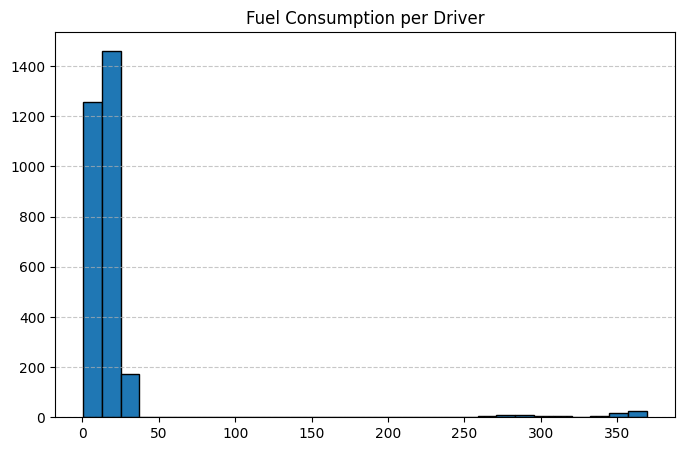

In [ ]:
# Plot histogram of fuel consumption per driver in the intersection dataset
plt.figure(figsize=(8, 5))
plt.hist(fc_per_driver_ins['FuelConsumption'], bins=30, edgecolor='black')
plt.title('Fuel Consumption per Driver')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Dataset Roundabout With Intersection

*   DataFrame VMs
*   DataFrame Fuel Consumption
*   DataFrame Original
*   DataFrame Drivers Behavior





In [ ]:
# Combine roundabout and intersection datasets into one dataframe
merged_df_vm = pd.concat([final_VM_round, final_VM_ins], ignore_index=True)

In [ ]:
# Add infrastructure type 'intersection' to the driver behavior dataset
Drive_Behavior_ins['infrastructure'] ='intersection'

In [ ]:
# Merge roundabout and intersection driver behavior datasets
merged_df_Behavior = pd.concat([Drive_Behavior_round, Drive_Behavior_ins], ignore_index=True)

In [ ]:
# Add infrastructure type 'roundabout' to the fuel consumption dataset
fc_per_driver_round['infrastructure'] = 'roundabout'

In [ ]:
# Add infrastructure type 'intersection' to the fuel consumption dataset
fc_per_driver_ins['infrastructure'] = 'intersection'

In [ ]:
# Combine fuel consumption data from roundabout and intersection datasets
merged_df_fc = pd.concat([fc_per_driver_round, fc_per_driver_ins], ignore_index=True)

In [ ]:
# Merge original roundabout and intersection datasets into one dataframe
merged_df_original = pd.concat([df_original_round, df_original_ins], ignore_index=True)

In [ ]:
# Remove duplicate driver entries from all merged datasets based on recordingId and trackId
df_behavior_cleaned = merged_df_Behavior.drop_duplicates(subset=['recordingId', 'trackId'])
df_fc_cleaned = merged_df_fc.drop_duplicates(subset=['recordingId', 'trackId'])
df_original_cleaned = merged_df_original.drop_duplicates(subset=['recordingId', 'trackId'])
df_vm_cleaned = merged_df_vm.drop_duplicates(subset=['recordingId', 'trackId'])

In [ ]:
# Merge driver behavior data with fuel consumption data
final_df = pd.merge(df_behavior_cleaned, df_fc_cleaned, on=['recordingId', 'trackId'], how='inner')

In [ ]:
# Merge VM features with the combined behavior and fuel consumption data
final_df= pd.merge(df_vm_cleaned, final_df, on=['recordingId', 'trackId'], how='inner')

In [ ]:
# Merge original dataset with the final combined dataframe
final_df= pd.merge(df_original_cleaned, final_df, on=['recordingId', 'trackId'], how='inner')

In [ ]:
# Display all column names in the final dataframe
final_df.columns

Index(['recordingId', 'trackId', 'lonVelocity', 'lonAcceleration', 'xCenter',
       'yCenter', 'frame', 'xAcceleration', 'distance', 'dt', 'VM1', 'VM2',
       'VM3', 'VM4', 'VM5', 'VM6', 'VM7', 'VM8', 'VM9', 'VM10',
       'infrastructure', 'cluster_x', 'infrastructure_x', 'cluster_y',
       'Driver Behavior', 'FuelConsumption', 'infrastructure_y'],
      dtype='object')

In [ ]:
# Clean up final dataframe by keeping main cluster and infrastructure columns, and removing unnecessary ones
final_df['cluster'] = final_df['cluster_x']
final_df['infrastructure'] = final_df['infrastructure_x']
final_df.drop(columns=['infrastructure_x', 'infrastructure_y','xCenter','yCenter','distance','dt','recordingId', 'trackId','frame','xAcceleration','cluster_x','cluster_y'], inplace=True)

In [ ]:
# Display dataset shape, preview, info, feature statistics, and missing value count
print(final_df.shape)
print(final_df.head())
print(final_df.info())
print(final_df[['FuelConsumption'] + [f'VM{i}' for i in range(1,11)]].describe().T)


print(final_df.isna().sum())

(5173, 16)
   lonVelocity  lonAcceleration       VM1       VM2        VM3        VM4  \
0       1.4076          -0.0314  0.715703  0.490298  46.118817  50.475381   
1       5.8926           0.6509  1.620171  0.342863   9.554758  47.312857   
2       1.5229          -0.6954  1.191643  0.627668  88.239574  76.820458   
3       0.0883          -0.0879  0.630152  0.626088  64.901363  70.740393   
4      10.0160           1.5534  0.423358  0.377068   3.736767  87.898058   

          VM5       VM6       VM7        VM8        VM9       VM10  \
0   76.918120  2.461401  0.323186  33.552756  37.979488  42.645972   
1   58.407086  0.599310  0.127609   7.642206  39.785212  52.225486   
2  113.871009  3.061694  0.451534  96.208715  61.372403  91.279688   
3   98.015789  2.501757  0.420679  48.477790  63.203781  62.680810   
4   56.862096  0.317870  0.276543   2.024527  74.282954  43.510204   

  infrastructure Driver Behavior  FuelConsumption  cluster  
0     roundabout    Conservative        12.3

In [ ]:
final_df.describe()

,lonVelocity,lonAcceleration,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10,FuelConsumption,cluster
count,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5171.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000
mean,7.745323,0.611790,0.968598,0.753882,33.499717,73.460153,67.053333,1.488020,0.396860,27.303734,52.630906,52.427578,16.026082,0.976223
std,3.893532,0.953206,0.498252,0.333194,37.446652,28.958831,26.653691,0.981261,0.168183,34.207418,19.125405,21.636390,6.563168,0.795880
min,-0.714160,-3.479600,0.091222,0.115938,0.641658,23.313102,0.000000,0.041109,0.004862,-863.742690,4.391198,0.000000,1.548752,0.000000
25%,4.868700,-0.032200,0.558422,0.494503,9.226144,55.136728,48.546093,0.667870,0.274888,5.958835,39.642304,36.240615,11.361594,0.000000
50%,7.331400,0.591800,0.889492,0.687956,22.288779,67.275601,61.592732,1.342602,0.384403,16.345746,51.608497,49.715444,15.325314,1.000000
75%,10.454420,1.343340,1.304020,0.970335,47.616921,84.014402,79.822907,2.153238,0.500251,39.252287,64.737397,68.612619,19.856253,2.000000
max,26.161320,5.245100,2.973676,3.206272,870.368438,456.671186,356.012915,5.591211,3.260603,724.860853,100.000000,99.435116,162.000485,2.000000


**visualizations**

<Axes: >

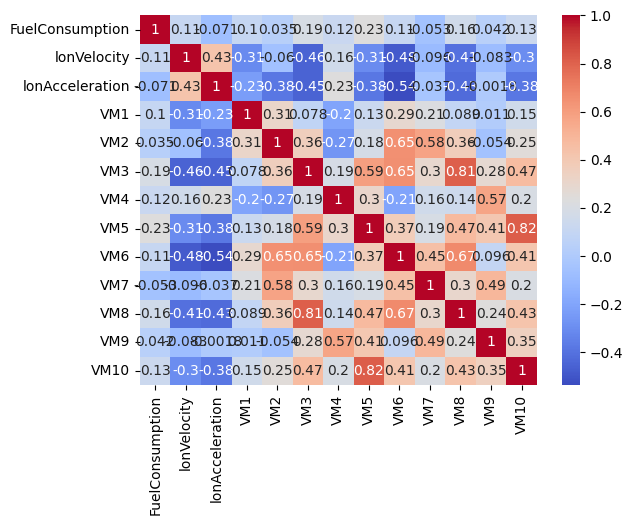

In [ ]:
# Plot correlation heatmap between fuel consumption, motion variables, and VM features
VM_columns = [f'VM{i}' for i in range(1, 11)]
corr = final_df[['FuelConsumption', 'lonVelocity', 'lonAcceleration'] + VM_columns ].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm') # High values ​​(close to ±1) = strong effect.

In [ ]:
#Direct relationship: The higher the longitudinal speed, the higher the fuel consumption.
#Inverse or non-linear relationship: Depending on driving style.
px.scatter(final_df, x='lonVelocity', y='FuelConsumption', trendline='ols', color='cluster')
px.scatter(final_df, x='lonAcceleration', y='FuelConsumption', trendline='ols', color='cluster')

In [ ]:
#Comparison of fuel consumption between modes (Normal, Aggressive, Conservative).
px.box(final_df, x='cluster', y='FuelConsumption', color='Driver Behavior')

In [ ]:
df_model_regression = final_df.copy()

In [ ]:
df_model_regression.columns


Index(['lonVelocity', 'lonAcceleration', 'VM1', 'VM2', 'VM3', 'VM4', 'VM5',
       'VM6', 'VM7', 'VM8', 'VM9', 'VM10', 'infrastructure', 'Driver Behavior',
       'FuelConsumption', 'cluster'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_model_regression['FuelConsumption_Scaled'] = scaler.fit_transform(
    df_model_regression[['FuelConsumption']]
)


In [ ]:
df_model_regression

,lonVelocity,lonAcceleration,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10,infrastructure,Driver Behavior,FuelConsumption,cluster,FuelConsumption_Scaled
0,1.40760,-0.03140,0.715703,0.490298,46.118817,50.475381,76.918120,2.461401,0.323186,33.552756,37.979488,42.645972,roundabout,Conservative,12.378203,0,0.067494
1,5.89260,0.65090,1.620171,0.342863,9.554758,47.312857,58.407086,0.599310,0.127609,7.642206,39.785212,52.225486,roundabout,Normal,19.007266,1,0.108809
2,1.52290,-0.69540,1.191643,0.627668,88.239574,76.820458,113.871009,3.061694,0.451534,96.208715,61.372403,91.279688,roundabout,Aggressive,10.989242,2,0.058837
3,0.08830,-0.08790,0.630152,0.626088,64.901363,70.740393,98.015789,2.501757,0.420679,48.477790,63.203781,62.680810,roundabout,Conservative,17.400771,0,0.098796
4,10.01600,1.55340,0.423358,0.377068,3.736767,87.898058,56.862096,0.317870,0.276543,2.024527,74.282954,43.510204,roundabout,Normal,13.543449,1,0.074756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5168,7.37046,0.72277,0.652759,0.831364,21.515380,51.334502,51.082747,1.060533,0.354630,19.597542,43.887555,38.011668,intersection,Normal,13.730327,0,0.075920
5169,5.55809,0.18295,0.657777,1.018756,43.197214,45.660705,55.840125,2.179370,0.358631,41.020906,33.551733,50.692137,intersection,Normal,12.956910,0,0.071100
5170,11.59355,1.59515,0.396875,0.462327,3.416854,71.366534,56.897132,0.363153,0.493650,3.368542,65.424167,41.053829,intersection,Aggressive,7.534342,2,0.037305
5171,11.79153,1.37580,0.331928,0.423298,3.877777,109.214199,85.464171,0.389911,0.417723,3.207443,77.229647,88.792720,intersection,Aggressive,13.750939,2,0.076049


In [ ]:
df_model_regression.describe()

,lonVelocity,lonAcceleration,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10,FuelConsumption,cluster,FuelConsumption_Scaled
count,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5171.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000
mean,7.745323,0.611790,0.968598,0.753882,33.499717,73.460153,67.053333,1.488020,0.396860,27.303734,52.630906,52.427578,16.026082,0.976223,0.090229
std,3.893532,0.953206,0.498252,0.333194,37.446652,28.958831,26.653691,0.981261,0.168183,34.207418,19.125405,21.636390,6.563168,0.795880,0.040904
min,-0.714160,-3.479600,0.091222,0.115938,0.641658,23.313102,0.000000,0.041109,0.004862,-863.742690,4.391198,0.000000,1.548752,0.000000,0.000000
25%,4.868700,-0.032200,0.558422,0.494503,9.226144,55.136728,48.546093,0.667870,0.274888,5.958835,39.642304,36.240615,11.361594,0.000000,0.061158
50%,7.331400,0.591800,0.889492,0.687956,22.288779,67.275601,61.592732,1.342602,0.384403,16.345746,51.608497,49.715444,15.325314,1.000000,0.085861
75%,10.454420,1.343340,1.304020,0.970335,47.616921,84.014402,79.822907,2.153238,0.500251,39.252287,64.737397,68.612619,19.856253,2.000000,0.114100
max,26.161320,5.245100,2.973676,3.206272,870.368438,456.671186,356.012915,5.591211,3.260603,724.860853,100.000000,99.435116,162.000485,2.000000,1.000000


In [ ]:
# Check for missing values in the regression model dataset
df_model_regression.isnull().sum()

,0
lonVelocity,0
lonAcceleration,0
VM1,0
VM2,0
VM3,0
VM4,0
VM5,2
VM6,0
VM7,0
VM8,0


In [ ]:
# Fill missing values in VM5 with the column mean
df_model_regression["VM5"] = df_model_regression["VM5"].fillna(df_model_regression["VM5"].mean())

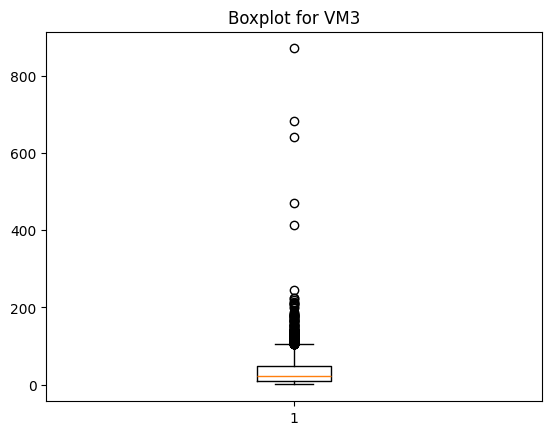

In [ ]:
# Plot boxplot to visualize outliers in VM3
plt.boxplot(df_model_regression["VM3"])
plt.title("Boxplot for VM3")
plt.show()

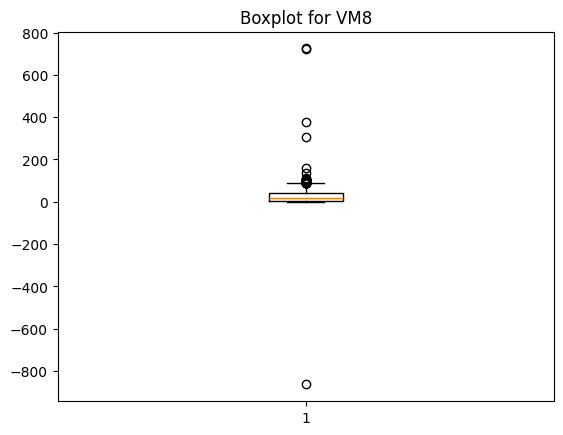

In [ ]:
# Plot boxplot to visualize outliers in VM8
plt.boxplot(df_model_regression["VM8"])
plt.title("Boxplot for VM8")
plt.show()

In [ ]:
# Remove outliers in VM3 and VM8 using the IQR (Interquartile Range) method
def clip_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

df_model_regression = clip_outliers(df_model_regression, 'VM3')
df_model_regression = clip_outliers(df_model_regression, 'VM8')

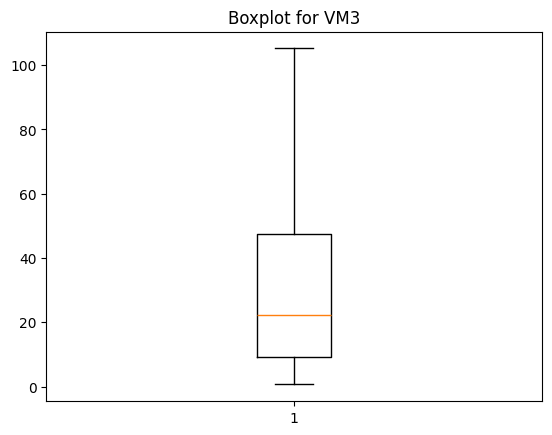

In [ ]:
# Plot boxplot again to confirm outliers in VM3 were handled
plt.boxplot(df_model_regression["VM3"])
plt.title("Boxplot for VM3")
plt.show()

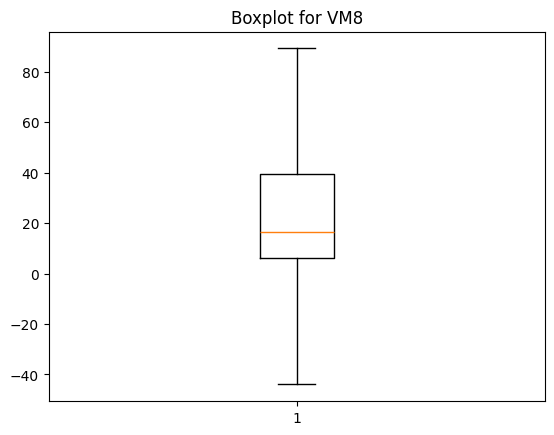

In [ ]:
# Plot boxplot again to confirm outliers in VM8 were handled
plt.boxplot(df_model_regression["VM8"])
plt.title("Boxplot for VM8")
plt.show()

In [ ]:
# Convert categorical columns into dummy variables for modeling
df_model_regression = pd.get_dummies(df_model_regression, columns=['infrastructure', 'Driver Behavior'], drop_first=False)

In [ ]:
# Convert boolean columns to integers (0 and 1) for model compatibility
bool_cols = df_model_regression.select_dtypes(include='bool').columns

df_model_regression[bool_cols] = df_model_regression[bool_cols].astype(int)


In [ ]:
df_model_regression

,lonVelocity,lonAcceleration,VM1,VM2,VM3,VM4,VM5,VM6,VM7,VM8,VM9,VM10,FuelConsumption,cluster,FuelConsumption_Scaled,infrastructure_intersection,infrastructure_roundabout,Driver Behavior_Aggressive,Driver Behavior_Conservative,Driver Behavior_Normal
0,1.40760,-0.03140,0.715703,0.490298,46.118817,50.475381,76.918120,2.461401,0.323186,33.552756,37.979488,42.645972,12.378203,0,0.067494,0,1,0,1,0
1,5.89260,0.65090,1.620171,0.342863,9.554758,47.312857,58.407086,0.599310,0.127609,7.642206,39.785212,52.225486,19.007266,1,0.108809,0,1,0,0,1
2,1.52290,-0.69540,1.191643,0.627668,88.239574,76.820458,113.871009,3.061694,0.451534,89.192464,61.372403,91.279688,10.989242,2,0.058837,0,1,1,0,0
3,0.08830,-0.08790,0.630152,0.626088,64.901363,70.740393,98.015789,2.501757,0.420679,48.477790,63.203781,62.680810,17.400771,0,0.098796,0,1,0,1,0
4,10.01600,1.55340,0.423358,0.377068,3.736767,87.898058,56.862096,0.317870,0.276543,2.024527,74.282954,43.510204,13.543449,1,0.074756,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5168,7.37046,0.72277,0.652759,0.831364,21.515380,51.334502,51.082747,1.060533,0.354630,19.597542,43.887555,38.011668,13.730327,0,0.075920,1,0,0,0,1
5169,5.55809,0.18295,0.657777,1.018756,43.197214,45.660705,55.840125,2.179370,0.358631,41.020906,33.551733,50.692137,12.956910,0,0.071100,1,0,0,0,1
5170,11.59355,1.59515,0.396875,0.462327,3.416854,71.366534,56.897132,0.363153,0.493650,3.368542,65.424167,41.053829,7.534342,2,0.037305,1,0,1,0,0
5171,11.79153,1.37580,0.331928,0.423298,3.877777,109.214199,85.464171,0.389911,0.417723,3.207443,77.229647,88.792720,13.750939,2,0.076049,1,0,1,0,0


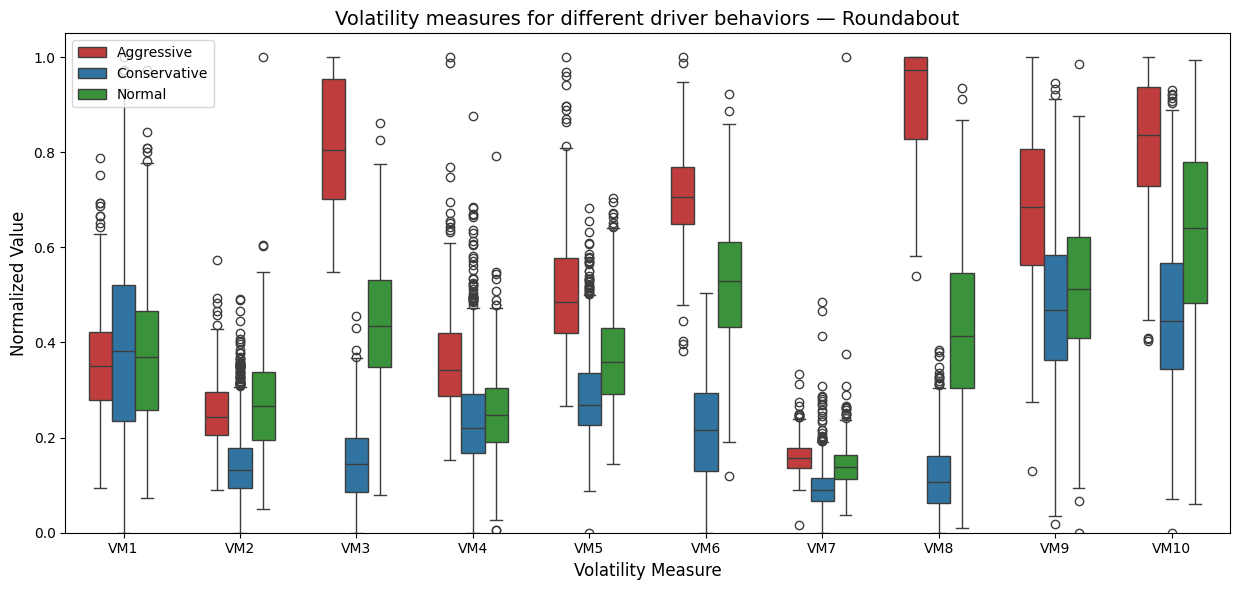

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

vm_cols = [f'VM{i}' for i in range(1, 11)]

round_df = df_model_regression[df_model_regression['infrastructure_roundabout'] == 1].copy()

long_round = round_df.melt(
    id_vars='cluster',
    value_vars=vm_cols,
    var_name='VM',
    value_name='value'
)

long_round['norm'] = long_round.groupby('VM')['value'].transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9))

num_to_name = {0: 'Normal', 1: 'Conservative', 2: 'Aggressive'}
long_round['Behavior'] = long_round['cluster'].map(num_to_name)

plt.figure(figsize=(12.5, 6))
sns.boxplot(
    data=long_round,
    x='VM', y='norm',
    hue='Behavior',
    hue_order=['Aggressive', 'Conservative', 'Normal'],
    palette={'Aggressive': '#d62728', 'Conservative': '#1f77b4', 'Normal': '#2ca02c'},
    showfliers=True, width=0.6
)

plt.ylim(0, 1.05)
plt.xlabel('Volatility Measure', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title('Volatility measures for different driver behaviors — Roundabout', fontsize=14)
plt.legend(title=None, loc='upper left')
plt.tight_layout()
plt.savefig('fig3_vm_box_roundabout.png', dpi=300)
plt.show()


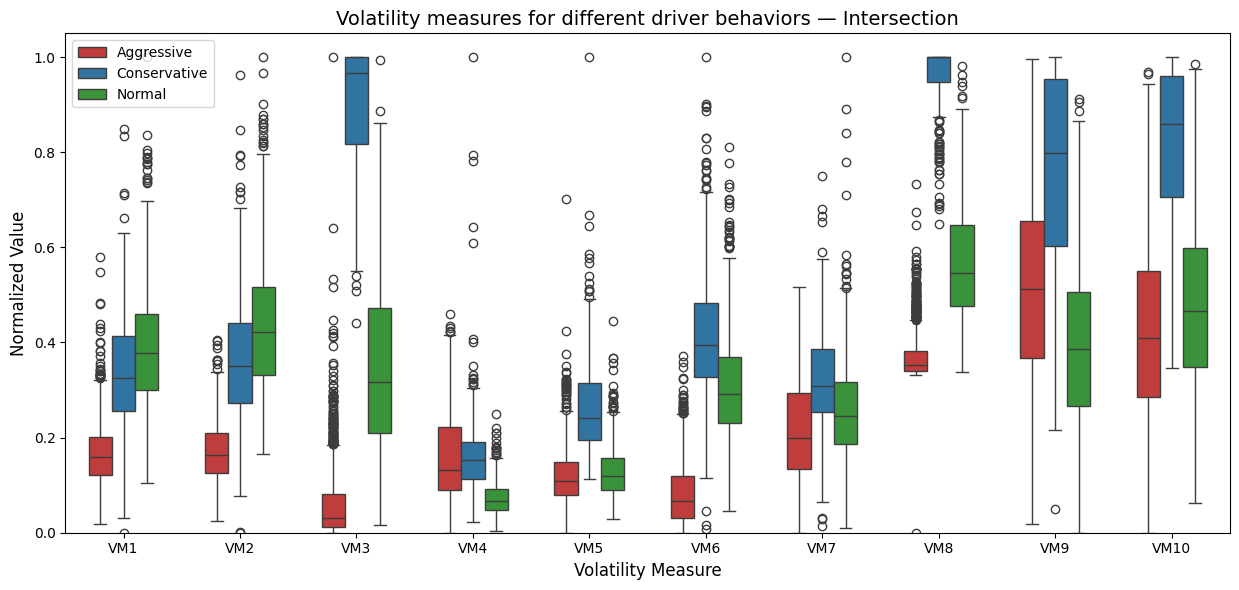

In [ ]:
inter_df = df_model_regression[df_model_regression['infrastructure_intersection'] == 1].copy()

long_inter = inter_df.melt(
    id_vars='cluster',
    value_vars=vm_cols,
    var_name='VM',
    value_name='value'
)

long_inter['norm'] = long_inter.groupby('VM')['value'].transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9))
long_inter['Behavior'] = long_inter['cluster'].map(num_to_name)

plt.figure(figsize=(12.5, 6))
sns.boxplot(
    data=long_inter,
    x='VM', y='norm',
    hue='Behavior',
    hue_order=['Aggressive', 'Conservative', 'Normal'],
    palette={'Aggressive': '#d62728', 'Conservative': '#1f77b4', 'Normal': '#2ca02c'},
    showfliers=True, width=0.6
)

plt.ylim(0, 1.05)
plt.xlabel('Volatility Measure', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title('Volatility measures for different driver behaviors — Intersection', fontsize=14)
plt.legend(title=None, loc='upper left')
plt.tight_layout()
plt.savefig('fig4_vm_box_intersection.png', dpi=300)
plt.show()


# Machine learning model

**Baseline prediction model**

In [ ]:
# Create a copy of the regression dataset for Baseline prediction modeling
df_model_BL = df_model_regression.copy()

In [ ]:
df_model_BL.drop(columns='cluster',inplace=True)

In [ ]:
df_model_BL.columns

Index(['lonVelocity', 'lonAcceleration', 'VM1', 'VM2', 'VM3', 'VM4', 'VM5',
       'VM6', 'VM7', 'VM8', 'VM9', 'VM10', 'FuelConsumption',
       'infrastructure_intersection', 'infrastructure_roundabout',
       'Driver Behavior_Aggressive', 'Driver Behavior_Conservative',
       'Driver Behavior_Normal'],
      dtype='object')

In [ ]:
yl = df_model_BL["FuelConsumption"]

In [ ]:
Xl = df_model_BL[['lonVelocity', 'lonAcceleration', 'VM1', 'VM2', 'VM3', 'VM4', 'VM5',
       'VM6', 'VM7', 'VM8', 'VM9', 'VM10', 'infrastructure_intersection', 'infrastructure_roundabout',
       'Driver Behavior_Aggressive', 'Driver Behavior_Conservative', 'Driver Behavior_Normal']]


In [ ]:
import statsmodels.api as sm
Xl = sm.add_constant(Xl)

In [ ]:
model = sm.OLS(yl, Xl).fit()

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        FuelConsumption   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     117.7
Date:                Fri, 14 Nov 2025   Prob (F-statistic):          1.81e-315
Time:                        10:44:10   Log-Likelihood:                -16311.
No. Observations:                5173   AIC:                         3.265e+04
Df Residuals:                    5157   BIC:                         3.276e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [ ]:
y_pred = model.predict(Xl)

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(yl, y_pred)
r2 = r2_score(yl, y_pred)

print("\nModel Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")


Model Evaluation:
R² Score: 0.2551
Mean Squared Error (MSE): 32.0805


**Random Forest**

In [ ]:
# Create a copy of the regression dataset for Random Forest modeling
df_model_RF = df_model_regression.copy()

In [ ]:
# Initialize Random Forest Regressor with 300 trees and enable out-of-bag scoring
import warnings
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')
# Fitting Random Forest Regression to the dataset
regressor1 = RandomForestRegressor(n_estimators=300, random_state=42, oob_score=True)

In [ ]:
df_model_RF.columns

Index(['lonVelocity', 'lonAcceleration', 'VM1', 'VM2', 'VM3', 'VM4', 'VM5',
       'VM6', 'VM7', 'VM8', 'VM9', 'VM10', 'FuelConsumption', 'cluster',
       'FuelConsumption_Scaled', 'infrastructure_intersection',
       'infrastructure_roundabout', 'Driver Behavior_Aggressive',
       'Driver Behavior_Conservative', 'Driver Behavior_Normal'],
      dtype='object')

In [ ]:
# Split data into features (X1) and target variable (y1)
X1 = df_model_RF.drop(columns=['FuelConsumption','cluster'], axis=1)
y1 = df_model_RF['FuelConsumption']

In [ ]:
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X1)

In [ ]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split( X1, y1, test_size=0.2, random_state=42)

In [ ]:
# Train the Random Forest Regressor on the entire dataset
regressor1.fit(X1, y1)

RandomForestRegressor(n_estimators=300, oob_score=True, random_state=42)

In [ ]:
# Evaluate Random Forest model using OOB score, MSE, and R-squared metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Access the OOB Score
oob_score = regressor1.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Making predictions on the same data or new data
predictions = regressor1.predict(X1)

# Evaluating the model
mse = mean_squared_error(y1, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y1, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.46395384319422794
Mean Squared Error: 3.1467550966942945
R-squared: 0.9269332414360377


In [ ]:
# Predict fuel consumption values on the test dataset
y_pred = regressor1.predict(X_test)

In [ ]:
# Compute feature importance using permutation importance on the trained Random Forest model
from sklearn.inspection import permutation_importance
import time
X4 = X1.drop(columns=['Driver Behavior_Aggressive','Driver Behavior_Conservative','Driver Behavior_Normal'])
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(X4, y1)

feature_names = ['lonVelocity','lonAcceleration','infrastructure_intersection','infrastructure_roundabout','VM1','VM2','VM3','VM4','VM5','VM6','VM7','VM8','VM9','VM10']
start_time = time.time()
result = permutation_importance(
    regressor, X4, y1, n_repeats=10, random_state=42, n_jobs=2)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 14.963 seconds


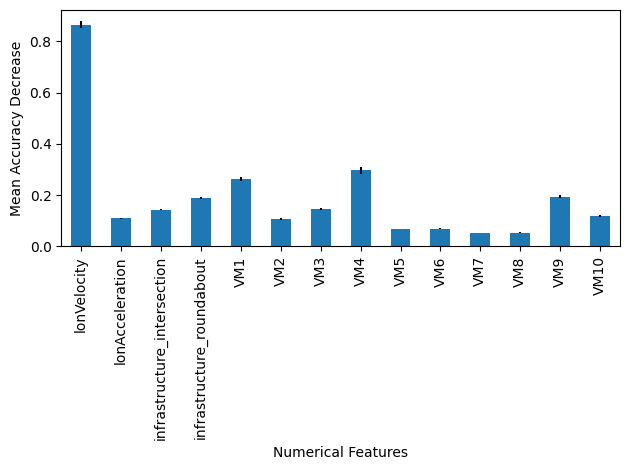

In [ ]:
# Plot bar chart of feature importances with error bars
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_ylabel("Mean Accuracy Decrease")
ax.set_xlabel("Numerical Features")
fig.tight_layout()
plt.savefig('Importance', dpi=600)
plt.show()

In [ ]:
# Create interactive bar chart of feature importances using Plotly
fig = px.bar(
    x=forest_importances.index,
    y=forest_importances.values,
    error_y=result.importances_std,
    labels={'x': 'Numerical Features', 'y': 'Mean Accuracy Decrease'},
    title='Feature Importances (Random Forest)',
)

fig.update_layout(
    title_x=0.5,
    template='plotly_white',
    width=800,
    height=500
)

fig.show()

**Linear Regression**

In [ ]:
# Prepare features (X2) and target (y2) for Linear Regression model
X2 = df_model_regression.drop(columns=['FuelConsumption','cluster'], axis=1)
y2 = df_model_regression['FuelConsumption']

In [ ]:
# Split data into training and testing sets for Linear Regression (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split( X2, y2, test_size=0.2, random_state=42)

In [ ]:
# Train Linear Regression model on the training data
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predict fuel consumption on the test set using the Linear Regression model
y_pred_lr = lin_reg.predict(X_test)

In [ ]:
# Evaluate Linear Regression model using Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 2.7310611116057535
R-squared: 0.9299696325540368


In [ ]:
# Plot comparison between Linear Regression and Random Forest predictions against actual values
fig = go.Figure()

# Linear Regression
fig.add_trace(go.Scatter(
    x=y_test,
    y=y_pred_lr,
    mode='markers',
    name='Linear Regression',
    marker=dict(color='blue', opacity=0.6)
))

# Random Forest
fig.add_trace(go.Scatter(
    x=y_test,
    y=y_pred,
    mode='markers',
    name='Random Forest',
    marker=dict(color='orange', opacity=0.6)
))

# Perfect Prediction Line
fig.add_trace(go.Scatter(
    x=[y_test.min(), y_test.max()],
    y=[y_test.min(), y_test.max()],
    mode='lines',
    name='Ideal Prediction Line',
    line=dict(color='red', width=3)
))

fig.update_layout(
    title='Comparison: Linear Regression vs Random Forest',
    xaxis_title='Actual Fuel Consumption',
    yaxis_title='Predicted Fuel Consumption',
    xaxis=dict(range=[0, 40]),
    legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.7)'),
    template='plotly_white',
    width=800,
    height=600
)

fig.show()

Linear Regression Feature Importance:


,Feature,Coefficient,Absolute Importance
0,VM7,-7.733265,7.733265
1,VM6,3.523506,3.523506
2,infrastructure_intersection,-1.626027,1.626027
3,infrastructure_roundabout,1.626027,1.626027
4,VM2,-1.210016,1.210016
5,lonVelocity,0.677648,0.677648
6,Driver Behavior_Normal,0.657351,0.657351
7,Driver Behavior_Aggressive,-0.651209,0.651209
8,VM1,-0.136669,0.136669
9,VM8,-0.123372,0.123372


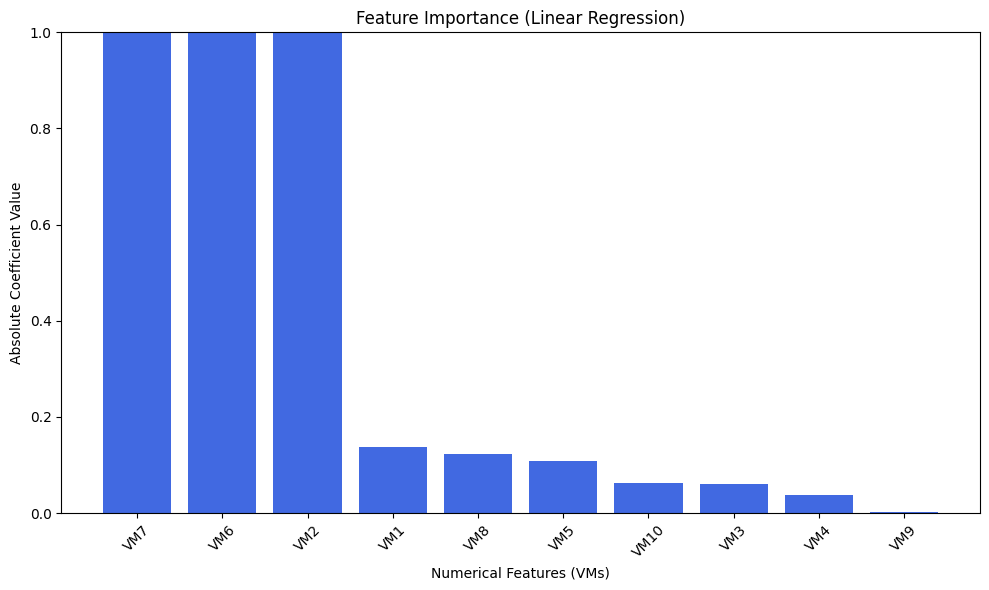

In [ ]:
feature_names = X_train.columns
coefficients = lin_reg.coef_

importance = np.abs(coefficients)
sorted_idx = np.argsort(importance)[::-1]

coef_df = pd.DataFrame({
    'Feature': feature_names[sorted_idx],
    'Coefficient': coefficients[sorted_idx],
    'Absolute Importance': importance[sorted_idx]
})

print("Linear Regression Feature Importance:")
display(coef_df)

vm_features = coef_df[coef_df['Feature'].str.contains('VM')]

plt.figure(figsize=(10,6))
plt.bar(vm_features['Feature'], vm_features['Absolute Importance'], color='royalblue')
plt.xticks(rotation=45)
plt.xlabel("Numerical Features (VMs)")
plt.ylabel("Absolute Coefficient Value")
plt.title("Feature Importance (Linear Regression)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


**Neural Networks**

In [ ]:
# Make a working copy to avoid modifying the original dataset
df_model_NNs = df_model_regression.copy()

In [ ]:
# Separate features (X) and target variable (y) for the neural network model
X = df_model_NNs.drop(columns=['FuelConsumption','cluster'], axis=1)
y = df_model_NNs['FuelConsumption']

In [ ]:
# Standardize feature values to improve neural network training stability
from sklearn.preprocessing import RobustScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
   X_scaled, y, test_size=0.2, random_state=42
)

In [ ]:
# Build and compile a deep neural network for regression with normalization and dropout regularization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


In [ ]:
# Train the neural network with early stopping and learning rate scheduling
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 257.4385 - mae: 14.8877 - val_loss: 170.6189 - val_mae: 10.3206 - learning_rate: 0.0010
Epoch 2/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 89.8462 - mae: 7.8159 - val_loss: 59.5164 - val_mae: 4.8498 - learning_rate: 0.0010
Epoch 3/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37.7851 - mae: 4.7637 - val_loss: 54.9388 - val_mae: 4.6127 - learning_rate: 0.0010
Epoch 4/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33.4650 - mae: 4.5968 - val_loss: 52.4246 - val_mae: 4.3896 - learning_rate: 0.0010
Epoch 5/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33.5114 - mae: 4.4990 - val_loss: 50.5659 - val_mae: 4.2899 - learning_rate: 0.0010
Epoch 6/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33.2222 - mae: 4.5490 - val_loss: 47.5050 - val_mae: 4.1704 - learning_rate: 0.0010
Epoch 7/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 31.5750 - mae: 4.5141 - val_loss: 49.6959 - val_mae: 4.3123 - l

In [ ]:
# Evaluate the neural network on the test set using R², MAE, and MSE metrics
y_pred = model.predict(X_test)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


In [ ]:
# Plot training and validation loss curves to monitor learning performance
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

**XGBoost**

In [ ]:
df_model_XG = df_model_regression.copy()

In [ ]:
from xgboost import XGBRegressor


X5 = df_model_XG.drop(columns=['FuelConsumption', 'cluster'], axis=1)
y5 = df_model_XG['FuelConsumption']
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y5, test_size=0.2, random_state=42
)

In [ ]:
model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.2,
    reg_lambda=5,
    min_child_weight=3,
    gamma=0.1,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=20,
    eval_metric="rmse"
)

In [ ]:
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")